# Lab 2:  Edge Detection & Hough Transform

Dario Del Gaizo, Giulia Rebay, Isabella Rositi

In [ ]:
#%reset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
''' DONT TOUCH UNLESS THE LAB IS COMPLETE
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/CV_Labs/lab2-computervision.ipynb
'''

' DONT TOUCH UNLESS THE LAB IS COMPLETE\n%%shell\njupyter nbconvert --to html /content/drive/MyDrive/CV_Labs/lab2-computervision.ipynb\n'

## Environment setup and function definition

In [ ]:
import os
import sys
sys.path.append('/content/drive/MyDrive/CV_Labs/modules')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy.fft import fft2, ifft2, fftshift
from scipy.signal import convolve2d, correlate2d

#from Functions import *
#from gaussfft import gaussfft
#from fftwave import fftwave

filepath = "/content/drive/MyDrive/CV_Labs/modules/Images-npy/"

In [ ]:
import math
import numpy as np
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.signal import convolve2d

#  SHOWGREY(IMAGE, DISPLAY, RESOLUTION, ZMIN, ZMAX)
#    displays the real matrix IMAGE as a gray-level image on the screen.
#
#  Arguments:
#    If RESOLUTION is a scalar value, RESOLUTION distinct gray-levels,
#    equidistantly spaced between 0 (black) and 1 (white), are used.
#    If RESOLUTION is a vector, its elements (which should lie in the
#    interval [ 0, 1]) are used as gray-levels (colormap).
#
#    The (matrix element) values ZMIN and ZMAX are mapped to black and
#    white respectively. For a quantized image, it is often advisable
#    to set ZMAX to the first quantization level outside actual range.
#    Values in ] ZMIN, ZMAX[ are mapped by linear interpolation, whereas
#    values outside this interval are mapped to either black or white by
#    truncation.
#
#    If ZMIN and ZMAX are omitted, they are set to the true max
#    and min values of the elements of IMAGE.
#
#    If RESOLUTION is also omitted, it is assumed to be 64.
#    If ZMIN = ZMAX, the displayed image is thresholded at ZMAX.
#
def showgrey(Image, display = True, res = 64, zmin = -1, zmax = -1):
	if zmin == -1:
		zmin = np.min(Image)
	if zmax == -1:
		zmax = np.max(Image)

	if not isinstance(res, list):
		col = np.linspace(0.0, 1.0, res)
	else:
		col = res
		res = len(col)

	range = 1.001*(zmax - zmin)
	if range == 0.0:
		range = 1e-10
	im = res*(Image.astype(np.float32) - zmin)/float(range)
	cols = np.array([ col, col, col ]).T
	cmap = ListedColormap(cols)
	plt.imshow(np.array(im, dtype=np.uint8), cmap)
	plt.axis('image')
	plt.axis('off')
	if display:
		plt.show()

#	SHOWFS( FREQSPEC, DISPLAY, RES) displays a compressed version
#	of the corresponding Fourier spectrum as a gray-level image.
#	RES distinct gray-levels, equidistantly spaced between 0 (black)
#	and 1 (white), are used. If RES is omitted, it is assumed to be 64.
#
def showfs(Image, display = True, res = 64):
	showgrey(np.log(1 + np.abs(np.fft.fftshift(Image))), display, res)


#	ROTIM = ROT( IMAGE, ANGLE, BKG) rotates the image IMAGE by an angle
#	ANGLE and sets the values of the background pixels to BKG.
#	If BKG is omitted, it is set to 0.
#	If ANGLE is also omitted, it is also set to 0.
#	This is not a very interesting rotation, but it will, like all
#	other values of ANGLE, create an output image ROTIM of size DxD,
#	where D = NORM( SIZE( IMAGE)), with the original image in the center.
#
def rot(Image, angle = 0, bkg = 0):
	imgsz = np.shape(Image)
	diam = np.linalg.norm(imgsz)
	s = math.sin(angle*np.pi/180.0)
	c = math.cos(angle*np.pi/180.0)
	rad2 = (diam - 1)/2
	outsz = math.ceil(diam)
	gridvec = np.linspace(-rad2, rad2, outsz)
	X2, Y2 = np.meshgrid(gridvec, gridvec)
	X = np.round(c*X2 - s*Y2 + imgsz[1]/2).astype(int)
	Y = np.round(s*X2 + c*Y2 + imgsz[0]/2).astype(int)
	mask = np.where((X>=0) & (X<imgsz[1]) & (Y>=0) & (Y<imgsz[0]), 1, 0)
	X = mask*X
	Y = mask*Y
	Rotim = np.ndarray([outsz, outsz])
	Rotim = mask*Image[Y, X] + (1 - mask)*bkg
	return Rotim

# POW2IMAGE(inpic, threshold) -- Power spectrum as negative power of two
# POW2IMAGE performs a transformation in the Fourier domain such
# that the phase information is preserved, whereas the magnitude
# is REPLACED BY a power spectrum of the form
# |Fourier|^2 \sim 1/(a + |omega|^2)
#
def pow2image(inpic, a = 0.001):
	ftransform = np.fft.fft2(inpic)
	# Generate the power spectrum in centered frequency coordinates
	#(note that the factor (pi/umax) corresponds to (2*pi/usize))
	[usize, vsize] = np.shape(ftransform)
	umax = int(usize/2)
	vmax = int(vsize/2)
	[u, v] = np.meshgrid(range(umax - usize, umax), range(vmax - vsize, vmax))
	pow2spectrum = 1/(a + (np.pi*u/umax)**2 + (np.pi*v/vmax)**2)
	# Move the origin of the power spectrum to the lower left corner
	pow2spectrum = np.fft.fftshift(pow2spectrum)
	# Replace the power spectrum (NOT a linear operation)
	modtransform = pow2spectrum * np.exp(complex(0,1) * np.angle(ftransform))
	return np.real(np.fft.ifft2(modtransform))

def randphaseimage(inpic):
	ftransform = np.fft.fft2(inpic)
	[xsize, ysize] = np.shape(ftransform)
	phase = 2.0*np.pi*(np.random.rand(xsize, ysize) - 0.5)
	modtransform = np.abs(ftransform) * np.exp(complex(0,1) * phase)
	return np.real(np.fft.ifft2(modtransform))

# DELTAFCN(xsize, ysize) -- generates a discrete delta function of
# support xsize*ysize, in which the central pixel is set to one and
# all other pixel values are set to zero.
#
def deltafcn(xsize, ysize):
	matrix = np.zeros([xsize, ysize])
	matrix[(int(xsize/2), int(ysize/2))] = 1
	return matrix

def variance(inpic):
	[usize, vsize] = np.shape(inpic)
	[x, y] = np.meshgrid(np.linspace(-(usize-1)/2, (usize-1)/2, int(usize)), np.linspace(-(vsize-1)/2, (vsize-1)/2, int(vsize)))
	abspic = np.abs(inpic)
	norm = np.sum(abspic)
	ex = np.sum(abspic * x)/norm
	ey = np.sum(abspic * y)/norm
	exx = np.sum(abspic * x*x)/norm
	exy = np.sum(abspic * x*y)/norm
	eyy = np.sum(abspic * y*y)/norm
	mat = np.zeros([2, 2])
	mat[(0, 0)] = exx - ex*ex
	mat[(0, 1)] = exy - ex*ey
	mat[(1, 0)] = mat[(0, 1)]
	mat[(1, 1)] = eyy - ey*ey
	return mat

# DISCGAUSSFFT(pic, sigma2) -- Convolves an image by the
# (separable) discrete analogue of the Gaussian kernel by
# performing the convolution in the Fourier domain.
# The parameter SIGMA2 is the variance of the kernel.
# Reference: Lindeberg "Scale-space theory in computer vision", Kluwer, 1994.
#
def discgaussfft(inpic, sigma2):
	pfft = np.fft.fft2(inpic)
	[h, w] = np.shape(inpic)
	[x, y] = np.meshgrid(np.linspace(0, 1-1/w, w),np.linspace(0, 1-1/h, h))
	ffft = np.exp(sigma2 * (np.cos(2*np.pi*x) + np.cos(2*np.pi*y) - 2))
	#print(np.shape(inpic), np.shape(ffft), np.shape(pfft))
	pixels = np.real(np.fft.ifft2(ffft * pfft))
	return pixels

# GAUSSNOISE(INPIC, SDEV, ZMIN, ZMAX) adds white (uncorrelated)
# Gaussian noise with standard deviation SDEV to INPIC.
# If the arguments ZMIN and ZMAX are specified and are unequal,
# the output values are truncated to the range [ZMIN, ZMAX]
#
def gaussnoise(inpic, sdev, zmin = 0, zmax = 0):
	noisy = inpic + np.random.normal(0, sdev, np.shape(inpic))
	if zmin < zmax:
		noisy = np.max(zmin, np.min(zmax, noisy))
	return noisy

# SAPNOISE( inpic, FRAC, ZMIN, ZMAX) adds salt-and-peppar noise to an
# image by resetting a fraction FRAC/2 of the pixels to ZMIN and a
# similar fraction to ZMAX in a pixel-to-pixel independent manner.
# If ZMIN and ZMAX are omitted, they are set to the true minimum and
# maximum values of inpic.
#
def sapnoise(inpic, frac, zmin = 1, zmax = 0):
	if zmin > zmax:
		zmin = np.min(inpic)
		zmax = np.max(inpic)
	noisy = inpic
	[u, v] = np.shape(inpic)
	Rand = np.random.rand(u, v)
	index = np.where(Rand < frac/2)
	noisy[index] = zmin
	index = np.where(Rand > 1 - frac/2)
	noisy[index] = zmax
	return noisy

# MEDIM = MEDFILT( IMAGE, WHEIGHT, WWIDTH) computes an output image
# MEDIM by applying a median filter with window height WHEIGHT and
# window width WWIDTH to the input image IMAGE.
# If WWIDTH is omitted, it is set to WHEIGHT.
#
def medfilt(Image, wheight, wwidth = -1):
	if wwidth == -1:
		wwidth = wheight
	result = scipy.ndimage.median_filter(Image, size=(wheight, wwidth))
	return result


# FILTIM = IDEAL( IMAGE, CUTOFF, FTYPE) filters the image IMAGE with
# an ideal high-pass or low-pass filter with cut-off frequency CUTOFF
# cycles per pixel and returns the resulting image FILTIM along with
# the modulation transfer function MTF.
# The filter is high-pass or low-pass depending on whether FTYPE = 'h'
# or FTYPE = 'l' respectively. If FTYPE is omitted, it is set to 'l'.
#
def ideal(Image, cutoff, ftype = 'l'):
	[u, v] = np.shape(Image)
	ur = np.linspace(-u/2, u/2-1, u)/u
	vr = np.linspace(-v/2, v/2-1, v)/v
	x, y = np.meshgrid(ur, vr)
	cutoff2 = cutoff * cutoff
	MTF = np.where(x**2 + y**2 > cutoff2, 0, 1)
	if ftype == 'h':
		MTF = 1 - MTF
	Filtim = np.real(np.fft.ifft2(np.fft.fftshift(MTF) * np.fft.fft2(Image)))
	return Filtim

# RAWSUBSAMPLE -- reduce image size by raw subsampling without presmoothing
# rawsubsample(image) reduces the size of an image by a factor of two in
# each dimension by raw subsampling, i.e., by picking out every second
# pixel along each dimension.
#
def rawsubsample(inpic):
	[h, w] = np.shape(inpic)
	[h2, w2] = [int(h/2), int(w/2)]
	newimg = np.zeros((h2, w2))
	ur = np.linspace(0, h2*2-2, h2)
	vr = np.linspace(0, w2*2-2, h2)
	[X, Y] = np.meshgrid(ur, vr)
	newimg = inpic[Y.astype(int), X.astype(int)]
	return newimg

# BINSUBSAMPLE -- subsampling with binomial presmoothing
#   binsubsample(image) reduces the size of an image by first smoothing
#   it with a two-dimensional binomial kernel having filter coefficients
#      (1/16  1/8  1/16)
#      ( 1/8  1/4  1/8)
#      (1/16  1/8  1/16)
#   and then subsampling it by a factor of two in each dimension.
def binsubsample(inpic):
	prefilterrow = np.array([[0.25, 0.50, 0.25]])
	prefilter = prefilterrow.T @ prefilterrow
	print(prefilter)
	presmoothpic = convolve2d(inpic, prefilter, 'same')
	pixels = rawsubsample(presmoothpic)
	return pixels

# MASK = CONTOUR( IMG) finds zero-crossings in an image by looking at the sign
# of the four naighbours and returns the zero-crossing points in MASK
#
def contour(img):
	[w, h] = np.shape(img)
	[x, y] = np.meshgrid(range(0, w), range(0, h))
	imgu = img[np.maximum(y-1, 0), x]
	imgd = img[np.minimum(y+1, h-1), x]
	imgl = img[y, np.maximum(x-1, 0)]
	imgr = img[y, np.minimum(x+1, w-1)]
	mask = ((img*imgu <= 0) & (np.abs(img)<np.abs(imgu)) |
		(img*imgl <= 0) & (np.abs(img)<np.abs(imgl)) |
		(img*imgr <= 0) & (np.abs(img)<np.abs(imgr)) |
		(img*imgd <= 0) & (np.abs(img)<np.abs(imgd))).astype(int)
	return mask

# ZEROCROSSCURVES(ZERO, MASK) -- Extraction of zero-crossing curves
# Computes the zero-crossing curves from the image ZERO
# If the MASK image is specified, only point on the zero-crossing
# curves for which the mask value is True are reserved
# The format of these curves is a tuple of two arrays with (Y,X) coordinates.
#
def zerocrosscurves(zeropic, mask):
	curves = np.where(contour(zeropic) & mask.astype(int))
	return curves

# THRESHOLDCURVES(CURVES, MASK) -- Thresholding of curves
# Returns a new set of curves containing only those points
# in the polygons for which the mask value is True.
# The format of these curves is a tuple of two arrays with (Y,X) coordinates.
#
def thresholdcurves(curves, mask):
	(Y, X) = curves
	m = mask[Y, X]
	X = X[m]
	Y = Y[m]
	return (Y, X)

# OVERLAYCURVES(IMAGE, CURVES)
# Displays CURVES overlayed on IMAGE
# The format of these curves is a tuple of two arrays with (Y,X) coordinates.
#
def overlaycurves(img, curves):
	[h, w] = np.shape(img)
	rgb = np.zeros((h, w, 3), dtype=np.uint8)
	rgb[:,:,0] = rgb[:,:,1] = rgb[:,:,2] = img
	(Y, X) = curves
	rgb[Y, X, 0] = 0
	rgb[Y, X, 1] = 0
	rgb[Y, X, 2] = 255
	plt.imshow(rgb)
	plt.axis('image')
	plt.axis('off')

# [POS, VALUE, ANMS] = LOCMAX8(A) finds the 8-connectedness local
# maxima of the matrix A and returns a array POS with the positions
# of the local maxima, a list VALUE with the corresponding local
# maximal values, and a matrix ANMS equal to A at the local maxima
# and set to 0 everywhere else.
#
def locmax8(A):
	[h, w] = np.shape(A)
	Aexp = np.zeros((h + 2, w + 2))
	Aexp[1:h + 1, 1:w + 1] = A
	Anms = np.ones(np.shape(A)).astype(bool)
	Anms = Anms & (A >= Aexp[0:h + 0, 0:w + 0])
	Anms = Anms & (A >= Aexp[0:h + 0, 1:w + 1])
	Anms = Anms & (A >= Aexp[0:h + 0, 2:w + 2])
	Anms = Anms & (A >= Aexp[1:h + 1, 0:w + 0])
	Anms = Anms & (A >  Aexp[1:h + 1, 2:w + 2])
	Anms = Anms & (A >  Aexp[2:h + 2, 0:w + 0])
	Anms = Anms & (A >  Aexp[2:h + 2, 1:w + 1])
	Anms = Anms & (A >  Aexp[2:h + 2, 2:w + 2])
	[Y, X] = np.where(Anms)
	Pos = np.concatenate((X.reshape(-1,1), Y.reshape(-1,1)), axis=1)
	Value = A[Y, X]
	Anms = np.zeros(np.shape(A))
	Anms[Y, X] = Value
	return Pos, Value, Anms

# IMEAN = MEAN_SEGMENTS(I, SEGM) computes the mean within clusters indexed per
# pixel by SEGM and returns in image with pixel values replaced by the means
#
def mean_segments(I, segm):
	Ivec = np.reshape(I, (-1, 3))
	idx = np.reshape(segm, (-1))
	L = np.max(idx) + 1
	centers = np.zeros((L, 3))
	h, _ = np.histogram(idx, L, (-0.5, L-0.5))
	for l in range(L):
		if h[l] > 0:
			centers[l,:] = np.mean(Ivec[idx == l], axis=0)
	return centers[segm,:]

# INEW = OVERLAY_BOUNDS(I, SEGM) creates a new image INEW with boundaries
# between clusters as indicated by the segmentation SEGM
#
def overlay_bounds(I, segm):
	(h, w) = np.shape(segm)
	grow = np.zeros((h + 1, w + 1), dtype = segm.dtype)
	grow[0:h,0:w] = segm
	mask = (segm != grow[1:h+1, 0:w]) | (segm != grow[0:h, 1:w+1])  | (segm != grow[1:h+1, 1:w+1])
	mask[0:h, w-1] = mask[h-1, 0:w] = False
	Inew = np.array(I)
	Inew[mask, 0] = 255
	Inew[mask, 1] = Inew[mask, 2] = 0
	return Inew


#1) Difference operators
Create two difference operators deltax() and deltay() that approximate first order partial derivatives in two orthogonal directions. You may choose to use either the simple difference operator, central differences, Robert’s diagonal operator or the Sobel operator.

In [ ]:
# Define filter masks that correspond to difference operators (approximating first order derivatives)

deltax = np.array([[0,0,0], [-1/2,0,1/2], [0,0,0]])      # x direction
deltay = np.array([[0,1/2,0], [0,0,0], [0,-1/2,0]])      # y direction

In [ ]:
# Load the image
tools = np.load(filepath + "few256.npy")

# Compute the first order derivatives in the coordinate directions
dxtools = convolve2d(tools, deltax, "valid")
dytools = convolve2d(tools, deltay, "valid")

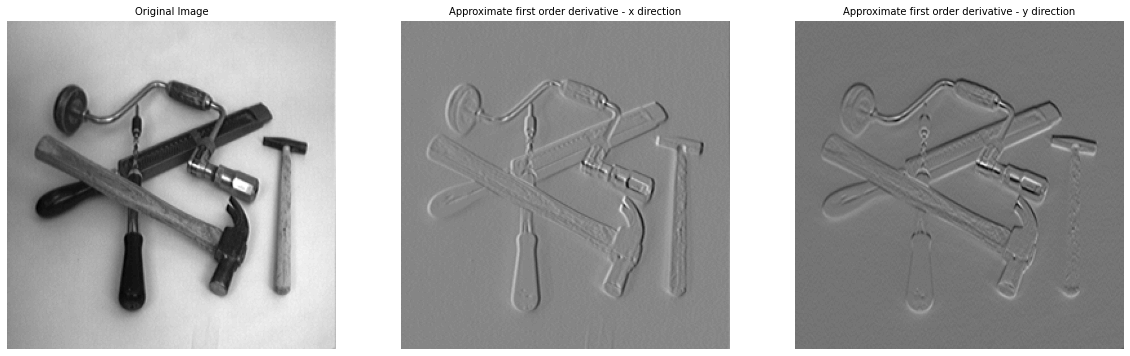

In [ ]:
# Display results

f = plt.figure(figsize = (20,10))
plt.rc('axes', titlesize=10)

a1 = f.add_subplot(1,3,1)
showgrey(tools, False)
a1.title.set_text("Original Image")

a2 = f.add_subplot(1,3,2)
showgrey(dxtools, False)
a2.title.set_text("Approximate first order derivative - x direction")

a3 = f.add_subplot(1,3,3)
showgrey(dytools, False)
a3.title.set_text("Approximate first order derivative - y direction")

**Question 1a:** What do you expect the results to look like and why?

Edges represent important discontinuities and are of adamant importance when performing feature detection. When computing the first order derivative of an image, whatever the direction, discontinuities will be captured and will appear like the only relevant features in the final convolved image. This is clearly shown in the figures above, where only edges appear clearly in both x and y cases.

It is interesting to note that edges are actually shaded differently in the two derivative images. This can be easily explained. In fact, vertical edges appear more clearly in the x derivative image since a vertical edge will result in bigger discontinuities when moving horizontally. The opposite will happen when looking at a horizontal edge, which is why shading is almost opposite in the y derivative image.

**Question 1b:** Compare the size of dxtools with the size of tools. Why are these sizes different?

In [ ]:
print("Tools is a " + str(np.size(tools, axis = 0)) + " by " + str(np.size(tools, axis = 1)) + " pixel image")
print("dxTools is a " + str(np.size(dxtools, axis = 0)) + " by " + str(np.size(dxtools, axis = 1)) + " pixel image")

Tools is a 256 by 256 pixel image
dxTools is a 254 by 254 pixel image


This is due to the fact that we are using Euler's finite differences to perform derivative computation. When doing so, the estimate for the x-derivative in one specific pixel location of the image is obtained by taking the difference between the value taken by the image on the pixel to the right and the value taken by the pixel to the left. This means that the first and last pixel columns of the original image will not be considered. Moreover, we also loose two pixel rows because of how the deltax and deltay operators have been defined, that is, 2D arrays. This is not strictly required for finite difference computation, but rather because the function convolve2d requires 2D arrays in input. Therefore, deltax is a 3 by 3 matrix whose first and last rows are zeros. This means that the very first and the very last rows of pixels will be ignored during derivative approximation, resulting in a final image of smaller size in both x and y directions (256 x 256 down to 254 x 254 pixels).

#2) Point–wise thresholding of gradient magnitudes
Based on the results above, compute an approximation of the gradient magnitude and show the results on screen. Compute the histogram of this image (using numpy.histogram()) and use this to guess a threshold that yields reasonably thin edges when applied to gradmagntools.

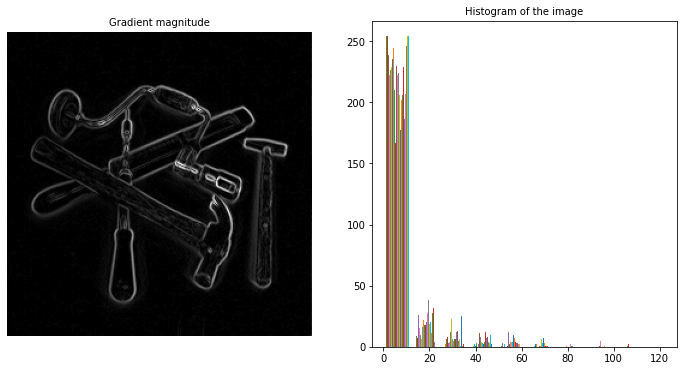

In [ ]:
# Approximation of the gradient magnitude
gradmagntools = np.sqrt(dxtools**2 + dytools**2)

# Display of results
f = plt.figure(figsize = (12,6))
plt.rc('axes', titlesize=10)

a1 = f.add_subplot(1,2,1)
showgrey(gradmagntools, False)
a1.title.set_text("Gradient magnitude")

a2 = f.add_subplot(1,2,2)
plt.hist(gradmagntools)
a2.title.set_text("Histogram of the image")

In [ ]:
# Let's also use the numpy function to guess a good threshold value
np.histogram(gradmagntools)

(array([56360,  4461,  1601,   907,   607,   342,   121,    63,    40,
           14]), array([  0.        ,  12.26234072,  24.52468145,  36.78702217,
         49.04936289,  61.31170361,  73.57404434,  85.83638506,
         98.09872578, 110.3610665 , 122.62340723]))

By looking at the obtained values, we can experiment with the following threshold values in order to find the one which yields reasonably thin edges:

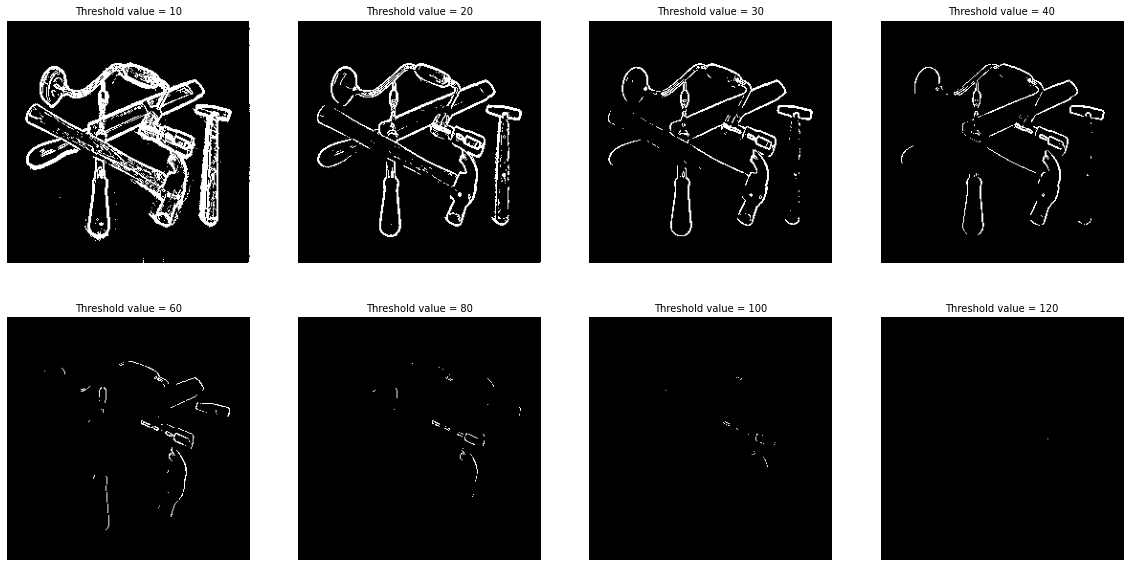

In [ ]:
# Set the threshold values
threshold = [10, 20, 30, 40, 60, 80, 100, 120]
N = 4

# Display results
f = plt.figure(figsize = (20,10))
plt.rc('axes', titlesize=10)

for i, t in enumerate(threshold):
    f.add_subplot(2,4,(i + 1), title = "Threshold value = " + str(t))
    showgrey((gradmagntools > t).astype(int), False)

By visual comparison of the plots above, the threshold yielding the most reasonably thin edges is **t = 20**. Indeed, if the threshold is set lower than 20, edges become excessively large and wide, resulting in unrealistic representation of the image. On the other hand, if t is set too high then features of the image aren't captured and representation is lost, as we can clearly see by looking at the extreme cases of **t = 80, 100, 120**.

Perform the same study on the image godthem256, whose content include image structures of higher complexity.

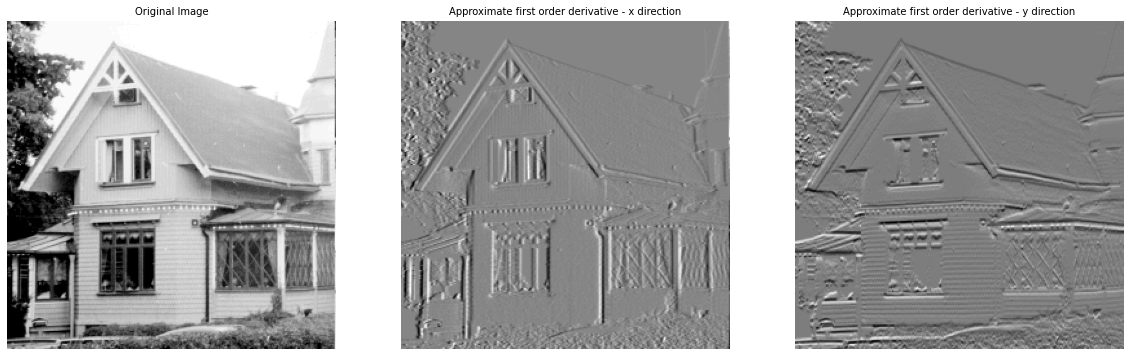

In [ ]:
# Load the image
house = np.load(filepath + "godthem256.npy")

# Compute the first order derivatives
dxhouse = convolve2d(house, deltax, "valid")
dyhouse = convolve2d(house, deltay, "valid")

# Plot the results side by side
f = plt.figure(figsize = (20,10))
plt.rc('axes', titlesize=10)

a1 = f.add_subplot(1,3,1)
showgrey(house, False)
a1.title.set_text("Original Image")

a2 = f.add_subplot(1,3,2)
showgrey(dxhouse, False)
a2.title.set_text("Approximate first order derivative - x direction")


a3 = f.add_subplot(1,3,3)
showgrey(dyhouse, False)
a3.title.set_text("Approximate first order derivative - y direction")

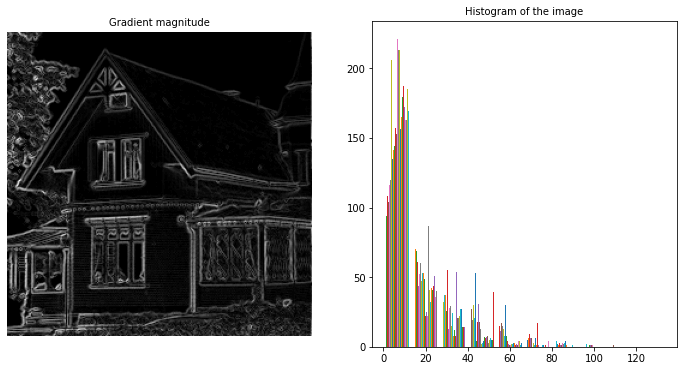

In [ ]:
# Approximation of the gradient magnitude
gradmagntools = np.sqrt(dxhouse**2 + dyhouse**2)

# Display of results
f = plt.figure(figsize = (12,6))
plt.rc('axes', titlesize=10)

a1 = f.add_subplot(1,2,1)
showgrey(gradmagntools, False)
a1.title.set_text("Gradient magnitude")

a2 = f.add_subplot(1,2,2)
plt.hist(gradmagntools)
a2.title.set_text("Histogram of the image")

In [ ]:
# Let's also use the numpy function to guess a good threshold value
np.histogram(gradmagntools)

(array([40590, 11416,  6106,  3336,  1761,   814,   371,   103,    15,
            4]), array([  0.        ,  13.39972015,  26.79944029,  40.19916044,
         53.59888059,  66.99860073,  80.39832088,  93.79804102,
        107.19776117, 120.59748132, 133.99720146]))

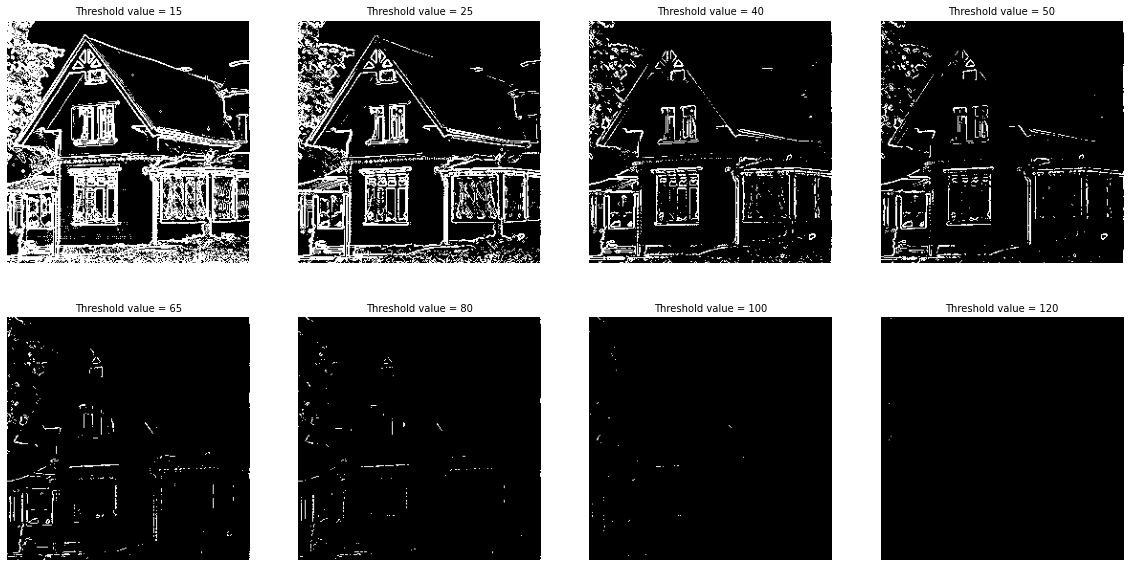

In [ ]:
# Set the threshold values
threshold = [15, 25, 40, 50, 65, 80, 100, 120]
N = 4

# Display results
f = plt.figure(figsize = (20,10))
plt.rc('axes', titlesize=10)

for i, t in enumerate(threshold):
    f.add_subplot(2,4,(i + 1), title = "Threshold value = " + str(t))
    showgrey((gradmagntools > t).astype(int), False)

In [ ]:
# Define new difference operators and a function returning the gradient magnitude
dxmask = np.array([[0,0,0], [-1/2,0,1/2], [0,0,0]])      # x direction
dymask = np.array([[0,1/2,0], [0,0,0], [0,-1/2,0]])      # y direction

def Lv(inpic, shape = "same"):
    Lx = convolve2d(inpic, dxmask, shape)
    Ly = convolve2d(inpic, dymask, shape)
    return np.sqrt(Lx**2 + Ly**2)

We are asked to combine gradient based edge detection with smoothing. To this end, we will be using the function gaussfft() developped in the previous lab. Indeed, we know that better edge detection results can be obtained by convolving the image by and appropriate smoothing filter prior to derivative computations.

In [ ]:
def gaussfft(pic, t):
    #get N and M of the image
    [h, w] = np.shape(pic)
    #get the sample of 2d gaussian using np.meshgrid
    [x, y] = np.meshgrid(np.linspace(0, 1-1/h, h), np.linspace(0, 1-1/w, w)) #128 points all equally spaced
    # fourier transform of the kernel
    ft_gauss = np.exp(t*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y) - 2))
    # fourier transform of the image
    ft = np.fft.fft2(pic)
    # convolution
    conv = ft * ft_gauss
    # transform the convulation into the spatial domain and only consider the real part (the imaginery part cancels out)
    im = np.real(np.fft.ifft2(conv))
    return im

We first of all have to guess the optimal value of the filter variance, in order to have high enough smoothing without feature loss and excessive noise suppression.

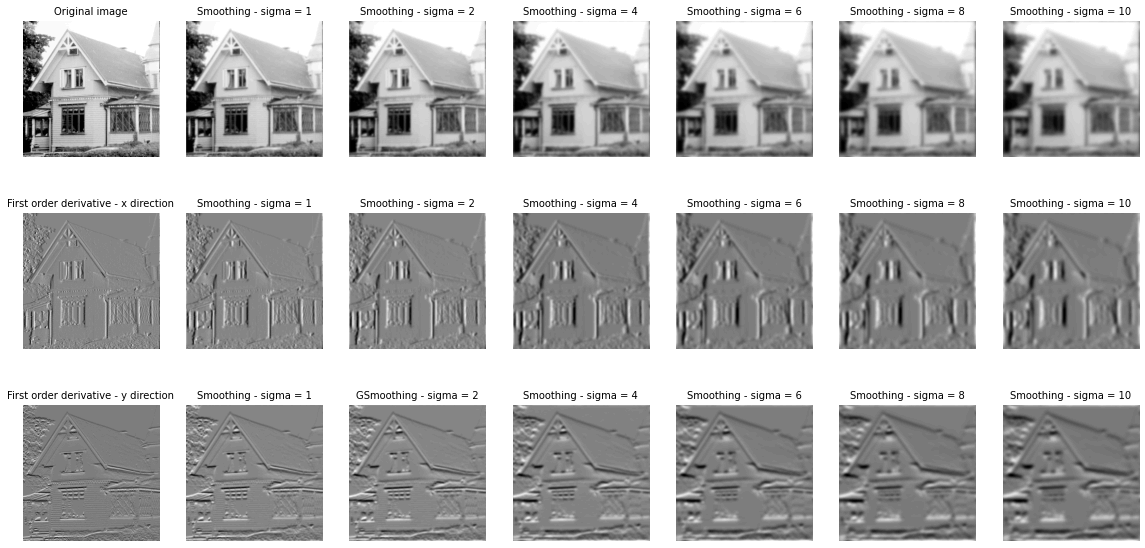

In [ ]:
# Set the variance values
s = [1, 2, 4, 6, 8, 10]

f = plt.figure(figsize = (20,10))
plt.rc('axes', titlesize=10)

# First row - Image
a1 = f.add_subplot(3,7,1)
showgrey(house, False)
a1.title.set_text("Original image")

a2 = f.add_subplot(3,7,2)
showgrey(gaussfft(house, s[0]), False)
a2.title.set_text("Smoothing - sigma = "+ str(s[0]))

a3 = f.add_subplot(3,7,3)
showgrey(gaussfft(house, s[1]), False)
a3.title.set_text("Smoothing - sigma = "+ str(s[1]))

a4 = f.add_subplot(3,7,4)
showgrey(gaussfft(house, s[2]), False)
a4.title.set_text("Smoothing - sigma = "+ str(s[2]))

a5 = f.add_subplot(3,7,5)
showgrey(gaussfft(house, s[3]), False)
a5.title.set_text("Smoothing - sigma = "+ str(s[3]))

a6 = f.add_subplot(3,7,6)
showgrey(gaussfft(house, s[4]), False)
a6.title.set_text("Smoothing - sigma = "+ str(s[4]))

a7 = f.add_subplot(3,7,7)
showgrey(gaussfft(house, s[5]), False)
a7.title.set_text("Smoothing - sigma = "+ str(s[5]))

# Second row - x derivative
a8 = f.add_subplot(3,7,8)
showgrey(dxhouse, False)
a8.title.set_text("First order derivative - x direction")

a9 = f.add_subplot(3,7,9)
showgrey(convolve2d(gaussfft(house, s[0]), deltax, "valid"), False)
a9.title.set_text("Smoothing - sigma = "+ str(s[0]))

a10 = f.add_subplot(3,7,10)
showgrey(convolve2d(gaussfft(house, s[1]), deltax, "valid"), False)
a10.title.set_text("Smoothing - sigma = "+ str(s[1]))

a11 = f.add_subplot(3,7,11)
showgrey(convolve2d(gaussfft(house, s[2]), deltax, "valid"), False)
a11.title.set_text("Smoothing - sigma = "+ str(s[2]))

a12 = f.add_subplot(3,7,12)
showgrey(convolve2d(gaussfft(house, s[3]), deltax, "valid"), False)
a12.title.set_text("Smoothing - sigma = "+ str(s[3]))

a13 = f.add_subplot(3,7,13)
showgrey(convolve2d(gaussfft(house, s[4]), deltax, "valid"), False)
a13.title.set_text("Smoothing - sigma = "+ str(s[4]))

a14 = f.add_subplot(3,7,14)
showgrey(convolve2d(gaussfft(house, s[5]), deltax, "valid"), False)
a14.title.set_text("Smoothing - sigma = "+ str(s[5]))

# Third row - y derivative
a15 = f.add_subplot(3,7,15)
showgrey(dyhouse, False)
a15.title.set_text("First order derivative - y direction")

a16 = f.add_subplot(3,7,16)
showgrey(convolve2d(gaussfft(house, s[0]), deltay, "valid"), False)
a16.title.set_text("Smoothing - sigma = "+ str(s[0]))

a17 = f.add_subplot(3,7,17)
showgrey(convolve2d(gaussfft(house, s[1]), deltay, "valid"), False)
a17.title.set_text("GSmoothing - sigma = "+ str(s[1]))

a18 = f.add_subplot(3,7,18)
showgrey(convolve2d(gaussfft(house, s[2]), deltay, "valid"), False)
a18.title.set_text("Smoothing - sigma = "+ str(s[2]))

a19 = f.add_subplot(3,7,19)
showgrey(convolve2d(gaussfft(house, s[3]), deltay, "valid"), False)
a19.title.set_text("Smoothing - sigma = "+ str(s[3]))

a20 = f.add_subplot(3,7,20)
showgrey(convolve2d(gaussfft(house, s[4]), deltay, "valid"), False)
a20.title.set_text("Smoothing - sigma = "+ str(s[4]))

a21 = f.add_subplot(3,7,21)
showgrey(convolve2d(gaussfft(house, s[5]), deltay, "valid"), False)
a21.title.set_text("Smoothing - sigma = "+ str(s[5]))

# Show results
plt.show()

By looking at the images plotted in the cell above, we can clearly see how Gaussian smoothing results in thicker and wider edges. This is reasonable, since smoothing blurs images - thus features - together, which will clearly result in thicker edge areas. This is in line with the fact that smoothing leads to features loosing granularity, sharpness and clear distinction between one another.

**Question 2:** Is it easy to find a threshold that results in thin edges? Explain why or why not!

We will here explore possible threshold values for four different situations:

*   Original image and its derivatives (no smoothing)
*   Smoothed versions of the original image and its derivatives, with **s = 2, 6, 10**

In [ ]:
# Compute gradient magnitude using defined function
gradmagnhouse = Lv(house, shape = "same")

# Save the smoothed versions of the image
house2  = gaussfft(house, s[1])                   # sigma = 2
house6  = gaussfft(house, s[3])                   # sigma = 6
house10 = gaussfft(house, s[5])                   # sigma = 10

# Save their derivatives
# sigma = 2
dxhouse2  = convolve2d(house2, deltax, "valid")
dyhouse2  = convolve2d(house2, deltay, "valid")

# sigma = 6
dxhouse6  = convolve2d(house6, deltax, "valid")
dyhouse6  = convolve2d(house6, deltay, "valid")

# sigma = 10
dxhouse10 = convolve2d(house10, deltax, "valid")
dyhouse10 = convolve2d(house10, deltay, "valid")

# Compute the corresponding gradient magnitude
gradmagnhouse2  = Lv(house2, shape = "same")
gradmagnhouse6  = Lv(house6, shape = "same")
gradmagnhouse10 = Lv(house10, shape = "same")

# Visualize histograms to get better insight in reasonable threshold values
print(np.histogram(gradmagnhouse))
print("\n\n")
print(np.histogram(gradmagnhouse2))
print("\n\n")
print(np.histogram(gradmagnhouse6))
print("\n\n")
print(np.histogram(gradmagnhouse10))

(array([42129, 11444,  5959,  3074,  1546,   708,   257,   132,   282,
           5]), array([  0.        ,  14.56468331,  29.12936663,  43.69404994,
        58.25873325,  72.82341656,  87.38809988, 101.95278319,
       116.5174665 , 131.08214981, 145.64683313]))



(array([47674, 12430,  3708,   950,   189,    87,    87,    98,    90,
         223]), array([1.69265735e-05, 1.18254944e+01, 2.36509720e+01, 3.54764495e+01,
       4.73019270e+01, 5.91274045e+01, 7.09528821e+01, 8.27783596e+01,
       9.46038371e+01, 1.06429315e+02, 1.18254792e+02]))



(array([54353,  8924,  1318,    70,   110,   246,   124,   111,    87,
         193]), array([4.32042053e-05, 1.10762918e+01, 2.21525404e+01, 3.32287889e+01,
       4.43050375e+01, 5.53812861e+01, 6.64575347e+01, 7.75337832e+01,
       8.86100318e+01, 9.96862804e+01, 1.10762529e+02]))



(array([57133,  7200,   222,    77,    97,   213,   192,   129,   121,
         152]), array([3.61322580e-04, 1.08091234e+01, 2.16178855e+01, 3.24266476e+0

Simply by looking at the histograms above, we can clearly see how smoothing the image results in much lower edge strength (lower gradient magnitude), which is reduced by several decimal points.

Let's visually explore this by plotting several thresholded versions of the gradient magnitude.

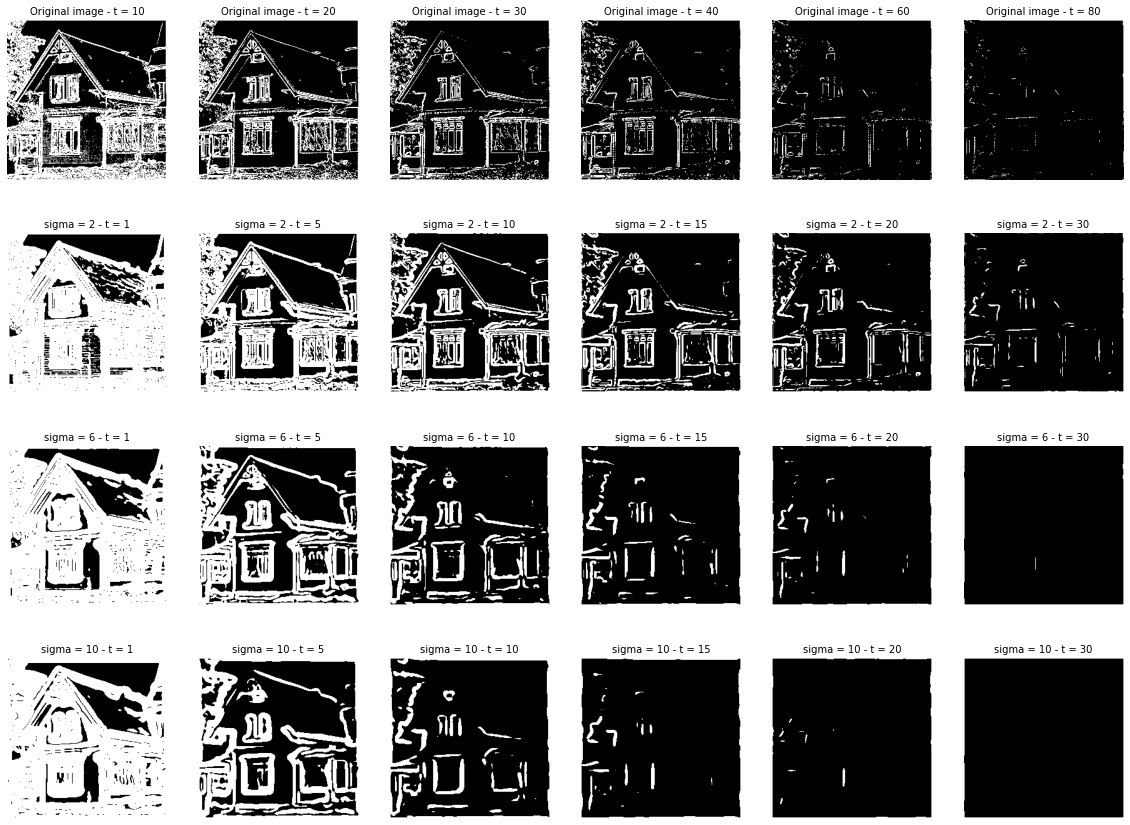

In [ ]:
# Set the threshold values
threshold = [10, 20, 30, 40, 60, 80]
N = len(threshold)

# Display results
f = plt.figure(figsize = (20,15))
plt.rc('axes', titlesize=10)

for i, t in enumerate(threshold):
    f.add_subplot(4,N,(i + 1), title = "Original image - t = " + str(t))
    showgrey((gradmagnhouse > t).astype(int), False)

# Set more reasonable threshold values for the smoothed images
threshold = [1, 5, 10, 15, 20, 30]
N = len(threshold)

for i, t in enumerate(threshold):
    f.add_subplot(4,N,(i + N + 1), title = "sigma = 2 - t = " + str(t))
    showgrey((gradmagnhouse2 > t).astype(int), False)

for i, t in enumerate(threshold):
    f.add_subplot(4,N,(i + 2*N +1), title = "sigma = 6 - t = " + str(t))
    showgrey((gradmagnhouse6 > t).astype(int), False)

for i, t in enumerate(threshold):
    f.add_subplot(4,N,(i + 3*N + 1), title = "sigma = 10 - t = " + str(t))
    showgrey((gradmagnhouse10 > t).astype(int), False)

We can now provide an answer to **Question 2**. By comparing the plots above, it is quite clear that finding the best fitting threshold for thin edges isn't always that straight-forward. This is particularly true when smoothing is applied to the image. If we just restrict to the original image, however, we can see that different threshold values will lead us to considering as edges or not some parts of the image. Setting an adequate threshold is very important, since it allows us to discard unwanted noise which the Laplacian might be
picking up on and to purely focus on actual edges. This is due to the fact that zero-crossings of the Laplacian can respond to false edges. This situation is depicted quite well when setting t = 10 in the original image: here the analysis of the image picks up on several image details which don't really correspond to an edge in practice (take a look, for example, at the facade of the house, which appears to be spotted despite there not being any edges there). This indicates that t = 10 is too low. On the contrary, when the threshold value is too high, we loose information on real edges, which will not appear on screen. This can already be seen when looking at the top border of the roof for t = 30.


**Question 3:** Does smoothing the image help to find edges?

Smoothing results in more confused features and less defined edges. However, it also allows us to (pretty much) completely remove noise from the image and only pick up on features that actually correspond to real edges. Therefore, while smoothing does result in more approximated and unrefined conclusions, it also allows us to bypass the "false edges" problem. In practice, when smoothing isn't excessive (cfr. sigma = 10, too high!), it does help us detect the most prominent edges and features in the image, without loosing too much time in small detail depiction. The best results are achieved when picking a smaller variance value for the Gaussian kernel (sigma = 2) and setting the threshold to t = 10. However, smoothing will generally result in thicker edges.

#3-4) Computing differential geometry descriptors

Write two functions Lvvtilde() and Lvvvtilde() that compute the differential expressions $\tilde{L_{vv}}$ and  $\tilde{L_{vvv}}$. Preferably, design this function in the same way as the function Lv() in exercise 2. You need to define masks corresponding to the discrete derivative approximations of all partial derivatives up to the order of three. The easiest way to do this is by using the central differences of the first order derivatives and simple difference approximations of the second order derivatives.

In [ ]:
def Lvvtilde(inpic, shape = "same"):
    # First order derivatives filter mask definition
    delta_x = np.array([[0,0,0,0,0], [0,0,0,0,0], [0,1/2,0,-1/2,0], [0,0,0,0,0], [0,0,0,0,0]])      # x direction
    delta_y = np.array([[0,0,0,0,0], [0,0,1/2,0,0], [0,0,0,0,0], [0,0,-1/2,0,0], [0,0,0,0,0]])      # y direction

    # Second order derivatives filter mask definition
    delta_xx = np.array([[0,0,0,0,0], [0,0,0,0,0], [0,1,-2,1,0], [0,0,0,0,0], [0,0,0,0,0]])      # x direction
    delta_yy = np.array([[0,0,0,0,0], [0,0,1,0,0], [0,0,-2,0,0], [0,0,1,0,0], [0,0,0,0,0]])      # y direction

    #Approximations of higher order derivatives
    delta_xy  = convolve2d(delta_x, delta_y,  shape)

    # Explicit computation of the partial derivatives of the input image
    # First order
    Lx  = convolve2d(inpic, delta_x, shape)
    Ly  = convolve2d(inpic, delta_y, shape)

    # Second order
    Lxx = convolve2d(inpic, delta_xx, shape)
    Lxy = convolve2d(inpic, delta_xy, shape)
    Lyy = convolve2d(inpic, delta_yy, shape)

    # Compute Lvvtilde
    Lvv_tilde = (Lx**2)*Lxx + 2*Lx*Ly*Lxy + (Ly**2)*Lyy
    return Lvv_tilde

In [ ]:
def Lvvvtilde(inpic, shape = "same"):
    # First order derivatives filter mask definition
    delta_x = np.array([[0,0,0,0,0], [0,0,0,0,0], [0,1/2,0,-1/2,0], [0,0,0,0,0], [0,0,0,0,0]])      # x direction
    delta_y = np.array([[0,0,0,0,0], [0,0,1/2,0,0], [0,0,0,0,0], [0,0,-1/2,0,0], [0,0,0,0,0]])      # y direction

    # Second order derivatives filter mask definition
    delta_xx = np.array([[0,0,0,0,0], [0,0,0,0,0], [0,1,-2,1,0], [0,0,0,0,0], [0,0,0,0,0]])      # x direction
    delta_yy = np.array([[0,0,0,0,0], [0,0,1,0,0], [0,0,-2,0,0], [0,0,1,0,0], [0,0,0,0,0]])      # y direction

    #Approximations of higher order derivatives
    delta_xy  = convolve2d(delta_x, delta_y,  shape)
    delta_xxx = convolve2d(delta_x, delta_xx, shape)
    delta_xxy = convolve2d(delta_xx, delta_y, shape)
    delta_xyy = convolve2d(delta_x, delta_yy, shape)
    delta_yyy = convolve2d(delta_y, delta_yy, shape)

    # Explicit computation of the partial derivatives of the input image
    # First order
    Lx  = convolve2d(inpic, delta_x, shape)
    Ly  = convolve2d(inpic, delta_y, shape)

    # Second order
    Lxx = convolve2d(inpic, delta_xx, shape)
    Lxy = convolve2d(inpic, delta_xy, shape)
    Lyy = convolve2d(inpic, delta_yy, shape)

    # Third order
    Lxxx = convolve2d(inpic, delta_xxx, shape)
    Lxxy = convolve2d(inpic, delta_xxy, shape)
    Lxyy = convolve2d(inpic, delta_xyy, shape)
    Lyyy = convolve2d(inpic, delta_yyy, shape)

    # Compute Lvvtilde
    Lvvv_tilde = (Lx**3)*Lxxx + 3*(Lx**2)*Ly*Lxxy + 3*Lx*(Ly**2)*Lxyy + (Ly**3)*Lyyy
    return Lvvv_tilde

In order to make sure that your filter masks have the expected effect, you should analyze their performances on some reference data. The easiest way to do this with NumPy is to define some matrices with x and y coordinates and study the results on, for example, the operations:

*   print(convolve2d(x**3, dxxxmask, "valid"))
*   print(convolve2d(x**3, dxxmask, "valid"))
*   print(convolve2d(x**2*y, dxxymask, "valid"))


In [ ]:
[x, y] = np.meshgrid(range(-5, 6), range(-5, 6))

delta_x = np.array([[0,0,0,0,0], [0,0,0,0,0], [0,1/2,0,-1/2,0], [0,0,0,0,0], [0,0,0,0,0]])      # x direction
delta_y = np.array([[0,0,0,0,0], [0,0,1/2,0,0], [0,0,0,0,0], [0,0,-1/2,0,0], [0,0,0,0,0]])      # y direction

# Second order derivatives filter mask definition
delta_xx = np.array([[0,0,0,0,0], [0,0,0,0,0], [0,1,-2,1,0], [0,0,0,0,0], [0,0,0,0,0]])      # x direction
delta_yy = np.array([[0,0,0,0,0], [0,0,1,0,0], [0,0,-2,0,0], [0,0,1,0,0], [0,0,0,0,0]])      # y direction

#Approximations of higher order derivatives
shape = "same"
delta_xy  = convolve2d(delta_x, delta_y,  shape)
delta_xxx = convolve2d(delta_x, delta_xx, shape)
delta_xxy = convolve2d(delta_xx, delta_y, shape)
delta_xyy = convolve2d(delta_x, delta_yy, shape)
delta_yyy = convolve2d(delta_y, delta_yy, shape)

print(convolve2d(x**3, delta_xxx, "valid"))
print("\n\n")
print(convolve2d(x**3, delta_xx, "valid"))
print("\n\n")
print(convolve2d(x**2*y, delta_xxy, "valid"))

[[6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6.]]



[[-18 -12  -6   0   6  12  18]
 [-18 -12  -6   0   6  12  18]
 [-18 -12  -6   0   6  12  18]
 [-18 -12  -6   0   6  12  18]
 [-18 -12  -6   0   6  12  18]
 [-18 -12  -6   0   6  12  18]
 [-18 -12  -6   0   6  12  18]]



[[2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2.]]


In [ ]:
# Test on polynomials
# 1. delta_x(x^n) = n*x*(n-1)
polynomial = x**4
print(convolve2d(polynomial, delta_x, "valid"))
print("\n\n")

# 2. delta_x^n(x^n) = n!
polynomial = x**3
print(convolve2d(polynomial, delta_xxx, "valid"))
print("\n\n")

# 3. delta_x^(n+k)(x^n) = 0
polynomial = 5*x+6
print(convolve2d(polynomial, delta_xxx, "valid"))
print("\n\n")

# 4. delta_x^n(y^k) = 0
polynomial = y**5
print(convolve2d(polynomial, delta_xxx, "valid"))
print("\n\n")

[[-120.  -40.   -8.    0.    8.   40.  120.]
 [-120.  -40.   -8.    0.    8.   40.  120.]
 [-120.  -40.   -8.    0.    8.   40.  120.]
 [-120.  -40.   -8.    0.    8.   40.  120.]
 [-120.  -40.   -8.    0.    8.   40.  120.]
 [-120.  -40.   -8.    0.    8.   40.  120.]
 [-120.  -40.   -8.    0.    8.   40.  120.]]



[[6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6.]]



[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]



[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]





Everything seems to work, so we proceed withh some **experiments** using the implemented Lvvtilde and Lvvvtilde functions.

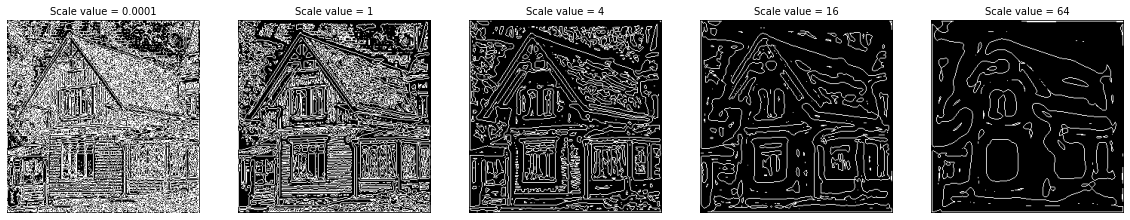

In [ ]:
# Compute the zero crossings of Lvvtilde on a number of different scales

# Set the scale parameters
scale = [0.0001, 1, 4, 16, 64]

# Display results
f = plt.figure(figsize = (20,10))
plt.rc('axes', titlesize=10)

for i, s in enumerate(scale):
    f.add_subplot(1,5,(i + 1), title = "Scale value = " + str(s))
    showgrey(contour(Lvvtilde(gaussfft(house, s), "same")), False)

**Question 4:** What can you observe? Provide explanation based on the generated images

When increasing the scale value, we are increasing the smoothing effect the gaussian kernel has on the image. This will result in **blurrier features**, **less defined edges** and therefore more **unrefined results**. Such trend can be clearly seen in the set of images above. Starting from the far left, where the scale value is very low and set to 0.0001, we can see how details in the image get lost as the scale value increases, until very little information of the original representation is left once scale gets up to 64. We are clearly looking at a trade-off situation, between detailed (yet probably noisy) representation of edges on the left and noise-free yet incomplete depiction on the right.
The optimal scale value is therefore between 1 and 4, where accurate depiction of features and edges is still visible yet we are not excessively tuning to noise and non-existent edges.

Study the sign of the third order derivative in the gradient direction in the case of the tools image. Show the result of command showgrey((Lvvvtilde(discgaussfft(tools, scale), "same") < 0).astype(int)) for the same values of scale.

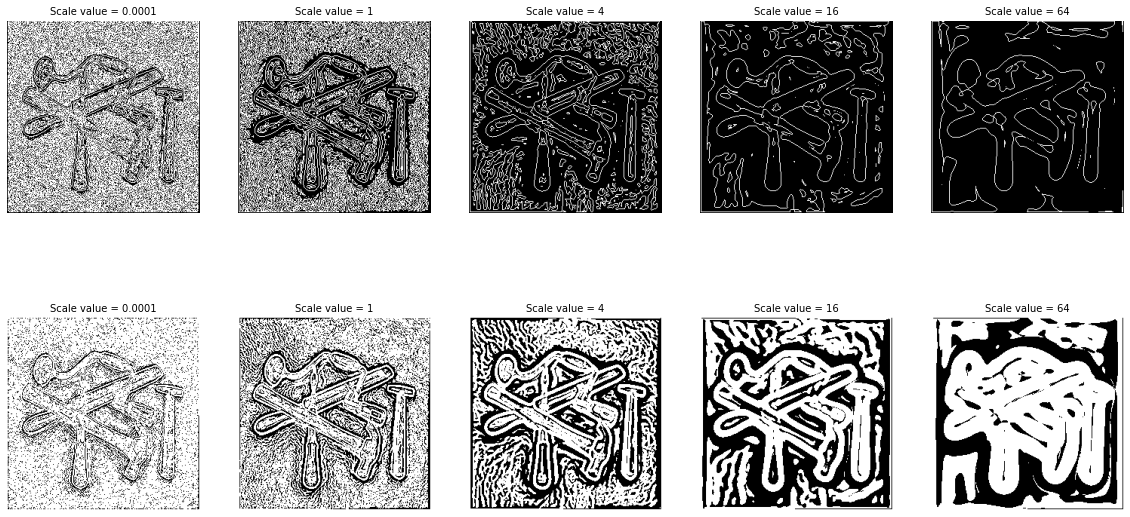

In [ ]:
# We will be both plotting the zero crossings of Lvvtilde, in the first row of the plot
# and we will study the sign of Lvvvtilde in the second row of the plot below.

# Display the image
f = plt.figure(figsize = (20,10))
plt.rc('axes', titlesize=10)

for i, s in enumerate(scale):
    f.add_subplot(2,5,(i + 1), title = "Scale value = " + str(s))
    showgrey(contour(Lvvtilde(gaussfft(tools, s), "same")), False)
    f.add_subplot(2,5,(i + 6), title = "Scale value = " + str(s))
    showgrey((Lvvvtilde(gaussfft(tools, s), "same") < 0).astype(int), False)

What is the effect of the sign condition in this differential expression?

Mathematically, points such that their second derivative is null and their third derivative (in the direction of the gradient) is negative are local maxima. If instead Lvvv were positive, they would be local minima. Therefore, the sign condition in the differential expression above allows us to identify and plot points that satisfy Lvvv < 0, thus helping us in efficient and effective edge detection. This is of upmost importance, since we know that extraction of thin edges can be done by zooming into points for which the gradient magnitude reaches local maxima in gradient direction. As already mentioned, this happens when both conditions on the second and third order derivatives are met.

**Question 5:** Assemble the results of the experiment above into an illustrative collage with the subplot command. Which are your observations and conclusions?

Several considerations can be made by looking at the plot above. We can first of all appreciate the effect the scale parameter has on the features of the image, which we have already discussed some cells above. What is even more interesting to point out is that plotting both Lvv = 0 and Lvvv < 0 conditions really does help us in clearly distinguishing generic features - and their noisy counterparts - and actual thin edges. The best results are achhieved with a scale value of 1, where noise is suppressed sufficiently but a good level of granularity is left, enabling us to clearly distinguish details in the image. It is also interesting to see how smoothing affects the third derivative more than it does the second. This can be seen by looking at how thicker edges get in the second row of the plot. As the scale parameter increases, features get blurred together and edges become thicker and more blunt. We therefore lose specificity and precision. We can also see that in both rows of the plot, thus in both order derivative cases, the areas which stand out are indeed the same, which shows us once again how both condition work toward the same goal of providing strong and consistent mathematical tools for edge detection. The first row carries more detail since the second derivative is zero also in the case of minima, which are completely disregarded and filtered out by the condition on the sign of the third order derivative.

**Question 6:** How can you use the response from $\tilde{L_{vv}}$ to detect edges, and how can you improve the result by using $\tilde{L_{vvv}}$?

As we have briefly explained in the previous answer, by zooming into the points that satisfy the condition $\tilde{L_{vv}}$ = 0 we are able to find both maxima and minima of the gradient magnitude. Since edges always correspond to the most abrupt variations in pixel values, we look for edges where the gradient magnitude is maximal. This is done by filtering out the minima, thus by adding to the previous condition also a sign condition on the third order derivative, $\tilde{L_{vvv}}$ < 0. This will improve the result as it will allow us to only focus on points that satisfy all conditions which have to be met in order for a point to belong to an edge. Clearly, $\tilde{L_{vv}}$ on its own also gives us very insightful information, but the mathematical conditions that being an edge involves are only fully described when both $\tilde{L_{vv}}$ and $\tilde{L_{vvv}}$ are used.

#5) Extraction of edge segments

So far we have only considered the result of computing differential operators at different scales and looked at their zero crossings and sign variations.

In [ ]:
def extractedge(inpic, scale, threshold=None, shape="same"): #This function combines the 2nd and 3rd order derivatives

    #smoothing
    pic_s = discgaussfft(inpic, scale)

    #Second order derivative of smoothed image
    Lvv = Lvvtilde(pic_s, shape)

    #Third order derivative of smoothed image
    Lvvv = Lvvvtilde(pic_s, shape)

    #Mask
    Lvvv_mask = (Lvvv < 0)

    #Look at when crossing zero
    edgecurves = zerocrosscurves(Lvv, Lvvv_mask)

    #if threshold is given:
    if threshold != None:

        #magnitude
        gradmagn = Lv(pic_s, shape)
        #create mask
        Lv_mask = (gradmagn > threshold)
        #new curves
        edgecurves = thresholdcurves(edgecurves, Lv_mask)

    return edgecurves

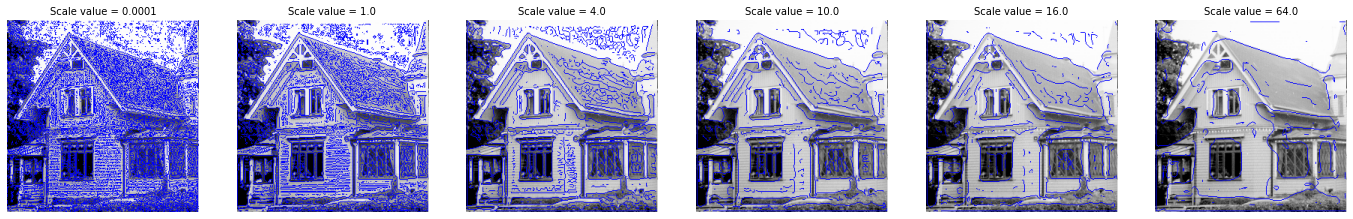

In [ ]:
scales = [0.0001, 1.0, 4.0, 10.0, 16.0, 64.0]

f = plt.figure(figsize = (24,10))
plt.rc('axes', titlesize=10)

for i, s in enumerate(scales):
    f.add_subplot(1,6,(i + 1), title = "Scale value = " + str(s))
    edgecurves = extractedge(house, s)
    overlaycurves(house, edgecurves)

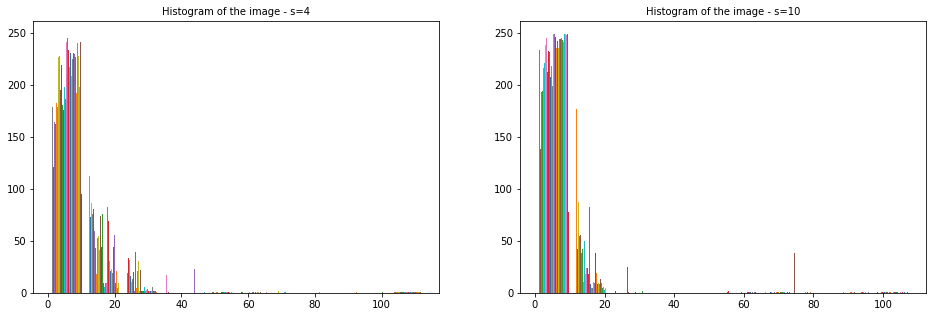

In [ ]:
# Compute gradient magnitude using defined function
gradmagnhouse = Lv(house, shape = "same")

# Save the smoothed versions of the image
house4  = gaussfft(house, scales[2])                   # sigma = 4
house10 = gaussfft(house, scales[3])                   # sigma = 10

# Save their derivatives
# sigma = 4
dxhouse2  = convolve2d(house4, deltax, "valid")
dyhouse2  = convolve2d(house4, deltay, "valid")

# sigma = 10
dxhouse10 = convolve2d(house10, deltax, "valid")
dyhouse10 = convolve2d(house10, deltay, "valid")

# Compute the corresponding gradient magnitude
gradmagnhouse4  = Lv(house4, shape = "same")
gradmagnhouse10 = Lv(house10, shape = "same")

# Display of results
f = plt.figure(figsize = (16,5))
plt.rc('axes', titlesize=10)

a1 = f.add_subplot(1,2,1)
plt.hist(gradmagnhouse4)
a1.title.set_text("Histogram of the image - s=4")

a2 = f.add_subplot(1,2,2)
plt.hist(gradmagnhouse10)
a2.title.set_text("Histogram of the image - s=10")

Scale = 4:


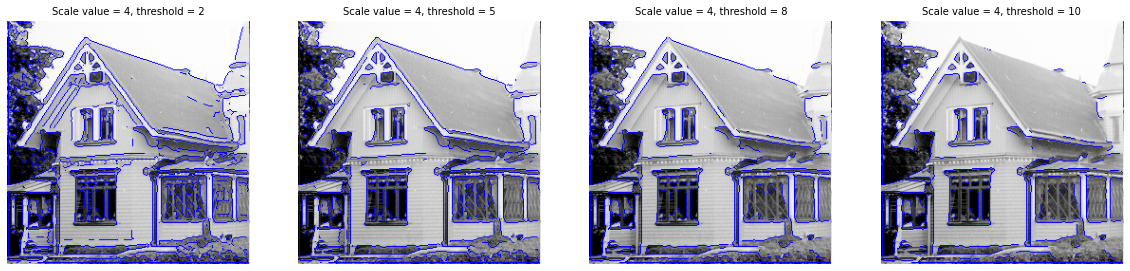

In [ ]:
thresholds = [2, 5, 8, 10]

f = plt.figure(figsize = (20,10))
plt.rc('axes', titlesize=10)

for i, t in enumerate(thresholds):
    f.add_subplot(1, len(thresholds) ,(i + 1), title = "Scale value = 4, threshold = " + str(t))
    edgecurves_t = extractedge(house, scales[2], t)
    overlaycurves(house, edgecurves_t)

Best edge extraction for threshold = 5.

Scale = 10:

In [ ]:
def thresholdcurves(curves, mask):
	(Y, X) = curves
	m = mask[Y, X]
	X = X[m]
	Y = Y[m]
	return (Y, X)

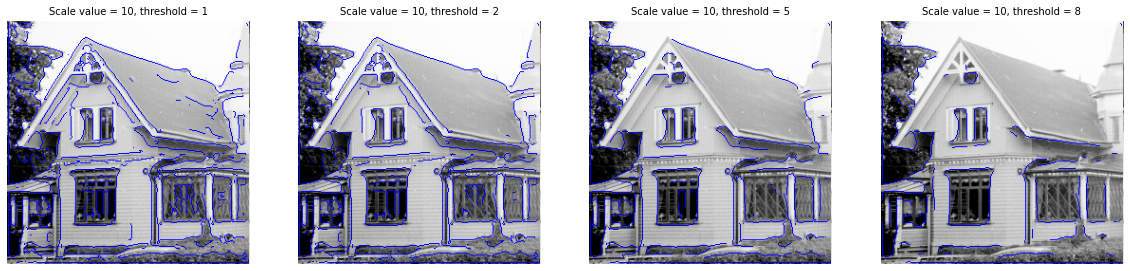

In [ ]:
thresholds = [1, 2, 5, 8]

f = plt.figure(figsize = (20,10))
plt.rc('axes', titlesize=10)

for i, t in enumerate(thresholds):
    f.add_subplot(1, len(thresholds),(i + 1), title = "Scale value = 10, threshold = " + str(t))
    edgecurves_t = extractedge(house, scales[3], t)
    overlaycurves(house, edgecurves_t)

Best edge extraction for threshold = 2.

Tools:

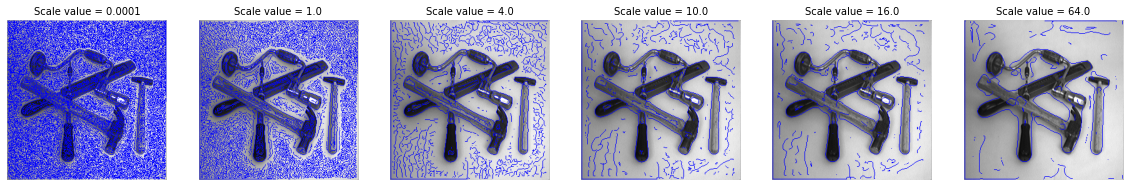

In [ ]:
scales = [0.0001, 1.0, 4.0, 10.0, 16.0, 64.0]

f = plt.figure(figsize = (20,10))
plt.rc('axes', titlesize=10)

for i, s in enumerate(scales):
    f.add_subplot(1,len(scales),(i + 1), title = "Scale value = " + str(s))
    edgecurves = extractedge(tools, s)
    overlaycurves(tools, edgecurves)

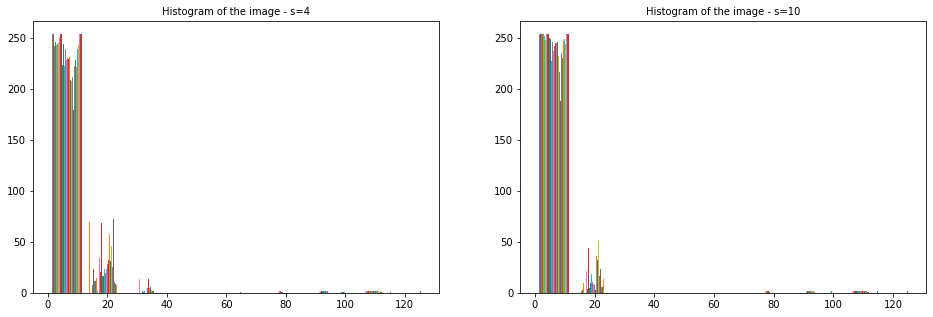

In [ ]:
# Compute gradient magnitude using defined function
gradmagntools = Lv(tools, shape = "same")

# Save the smoothed versions of the image
tools4  = gaussfft(tools, scales[2])                   # sigma = 4
tools10 = gaussfft(tools, scales[3])                   # sigma = 10

# Save their derivatives
# sigma = 4
dxtools2  = convolve2d(tools4, deltax, "valid")
dytools2  = convolve2d(tools4, deltay, "valid")

# sigma = 10
dxtools10 = convolve2d(tools10, deltax, "valid")
dytools10 = convolve2d(tools10, deltay, "valid")

# Compute the corresponding gradient magnitude
gradmagntools4  = Lv(tools4, shape = "same")
gradmagntools10 = Lv(tools10, shape = "same")

# Display of results
f = plt.figure(figsize = (16,5))
plt.rc('axes', titlesize=10)

a1 = f.add_subplot(1,2,1)
plt.hist(gradmagntools4)
a1.title.set_text("Histogram of the image - s=4")

a2 = f.add_subplot(1,2,2)
plt.hist(gradmagntools10)
a2.title.set_text("Histogram of the image - s=10")

Scale = 4:

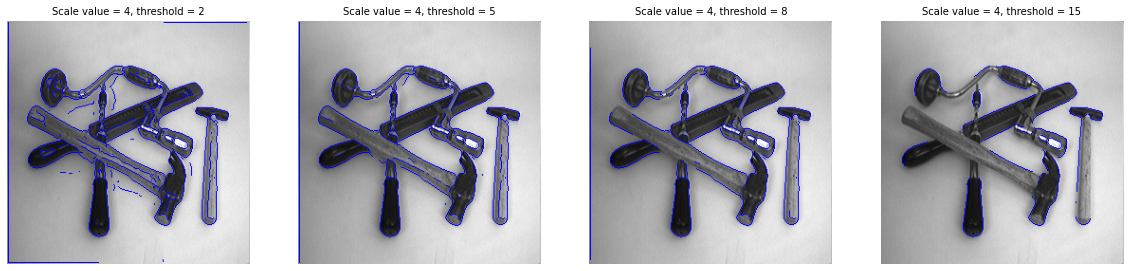

In [ ]:
thresholds = [2, 5, 8, 15]

f = plt.figure(figsize = (20,10))
plt.rc('axes', titlesize=10)

for i, t in enumerate(thresholds):
    f.add_subplot(1, len(thresholds),(i + 1), title = "Scale value = 4, threshold = " + str(t))
    edgecurves = extractedge(tools, scales[2], t)
    overlaycurves(tools, edgecurves)

Best edge extraction for threshold = 8.


Scale = 10:

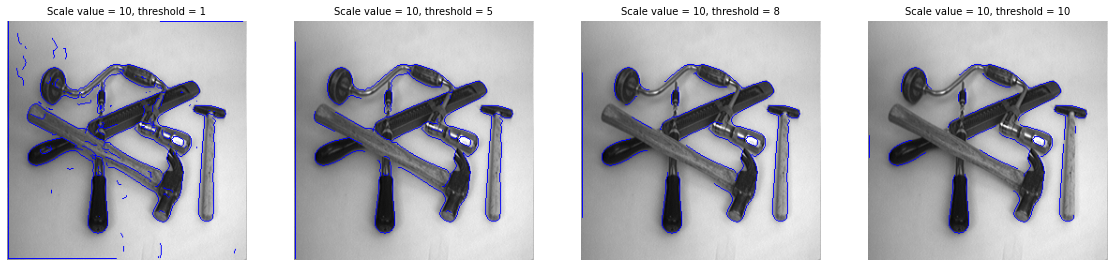

In [ ]:
thresholds = [1, 5, 8, 10]

f = plt.figure(figsize = (30,10))
plt.rc('axes', titlesize=10)

for i, t in enumerate(thresholds):
    f.add_subplot(1, len(threshold),(i + 1), title = "Scale value = 10, threshold = " + str(t))
    edgecurves_t = extractedge(tools, scales[3], t)
    overlaycurves(tools, edgecurves_t)

Best edge extraction for threshold = 5.

**Question 7:** The combination of scale and threshold that provides the best edge extraction are:

- **scale = 4** with **threshold = 5** for the house image
- **scale = 4** with **threshold = 8** for the tools image

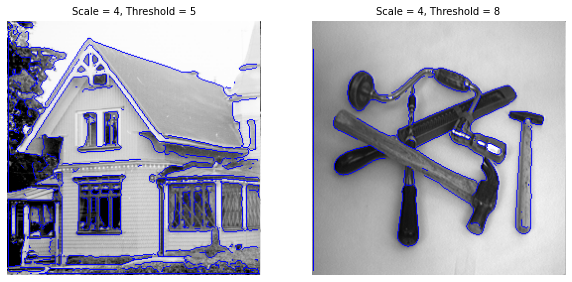

In [ ]:
f = plt.figure(figsize = (10,5))
plt.rc('axes', titlesize=10)

a1 = f.add_subplot(1,2,1)
edgecurves = extractedge(house, 4, 5)
overlaycurves(house, edgecurves)
a1.title.set_text("Scale = 4, Threshold = 5")

a2 = f.add_subplot(1,2,2)
edgecurves = extractedge(tools, 4, 8)
overlaycurves(tools, edgecurves)
a2.title.set_text("Scale = 4, Threshold = 8")

As previously mentioned, when extracting edges it is important both to smooth the image in order to apply the extraction to an image that has already reduced noise, and later apply a threshold to only extract those edges that result in a higher magnitude than the value provided. As we can see in the previous plots, For lower scales of smoothness, many of the edges extracted can be categorised as "false edges", resulting in a very noisy image. On the other hand, for high scale values we can see that the edges extracted are very approximative around the effective edges.

When applying a threshold, the higher the value, the less edges are taken into consideration since we increase the inferior limit of the magnitude value that these can have. Indeed, for very high values of thresholds, many real edges are once again not shown, and for very low values are kept also "false edges".

#6) Hough transform

- **linepar** is a list of (ρ, θ) parameters for each line segment
- **acc** is the accumulator matrix of the Hough transform


- **curves** are the edge points from which the transform is to be computed
- **magnitude** is an image with one intensity value per pixel (in exercise 6.2 you will here give the gradient magnitude as an argument)
- **nrho** is the number of accumulators in the ρ direction
- **ntheta** is the number of accumulators in the θ direction
- **threshold** is the lowest value allowed for the given magnitude
- **nlines** is the number of lines to be extracted
- **verbose** denotes the degree of extra information and figures that will be shown.

In [ ]:
def houghline(pic, curves, magnitude, nrho, ntheta, threshold, nlines=20,  increment="one", verbose=False):
    acc = np.zeros((nrho, ntheta))
    x, y = magnitude.shape
    r = np.sqrt(x * x + y * y)
    rho = np.linspace(-r, r, nrho)
    theta = np.linspace(-np.pi/2, np.pi/2, ntheta)
    for i in range(len(curves[0])):
        x = curves[0][i]
        y = curves[1][i]
        curveMagn = magnitude[x][y]
        if curveMagn > threshold:
            for j in range(ntheta):
                rhoVal = x * np.cos(theta[j]) + y * np.sin(theta[j])
                rhoIndex = np.argmin(abs(rho - rhoVal))
                if increment == "one":
                    acc[rhoIndex][j] += 1
                elif increment == "log":
                    acc[rhoIndex][j] += np.log(curveMagn)
                elif increment == "cubic":
                    acc[rhoIndex][j] += curveMagn**3




    linepar = []
    pos, value, _ = locmax8(acc)
    indexvector = np.argsort(value)[-nlines:]
    pos = pos[indexvector]

    f = plt.figure(figsize=(8, 8), dpi=200)
    f.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.rc('axes', titlesize=10)
    a1 = f.add_subplot(2, 2, 1)
    showgrey(pic, False)
    a1.title.set_text("original")
    a1 = f.add_subplot(2, 2, 2)
    showgrey(pic, False)
    for idx in range(nlines):
        thetaidxacc = pos[idx][0]
        rhoidxacc = pos[idx][1]
        rhoMax = rho[rhoidxacc]
        thetaMax = theta[thetaidxacc]
        linepar.append([rhoMax, thetaMax])

        x0 = rhoMax * np.cos(thetaMax)
        y0 = rhoMax * np.sin(thetaMax)
        dx = r * (-np.sin(thetaMax))
        dy = r * (np.cos(thetaMax))
        plt.plot([y0 - dy, y0, y0 + dy], [x0 - dx, x0, x0 + dx], "r-")


    a1.title.set_text("curves - increment: "+increment)
    a1 = f.add_subplot(2, 2, 3)
    showgrey(acc, False)

    a1.title.set_text("acc")
    a1 = f.add_subplot(2, 2, 4)
    overlaycurves(pic, curves)
    a1.title.set_text(" threshold=" + str(threshold) + " nrho=" + str(nrho) + " ntheta=" +
                      str(ntheta) + " nlines=" + str(nlines))
    plt.show()
    return linepar, acc

Additional arguments:

- pic is the grey-level image
- scale is the scale at which edges are detected
- gradmagnthreshold is the threshold of the gradient magnitude.

In [ ]:
def houghedgeline(pic, scale, gradmagnthreshold, nrho, ntheta, nlines=20, increment="one", verbose=False):
    curves = extractedge(pic, scale, gradmagnthreshold, "same")
    pic_s = discgaussfft(pic, scale)
    gradmagn = Lv(pic_s, "same")

    # if increment == 1:
    #   linepar, acc = houghline(pic, curves, gradmagn, nrho, ntheta, gradmagnthreshold, nlines, increment=1, verbose=verbose)
    # elif increment == "log":
    #   linepar, acc = houghline(pic, curves, gradmagn, nrho, ntheta, gradmagnthreshold, nlines, increment="log", verbose=verbose)
    # elif increment == "cubic":
    linepar, acc = houghline(pic, curves, gradmagn, nrho, ntheta, gradmagnthreshold, nlines, increment, verbose=verbose)

    return linepar, acc

In [ ]:
testimage1 = np.load(filepath+"triangle128.npy")
testimage2 = np.load(filepath+"houghtest256.npy")

**Question 8:** We tested the houghedgeline() function on the two test images and indeed, got satistactory results.

In the first image we can see that 3 lines are enough to describe the traingle perfectly.

In the second image, we need more nlines (15) in order to be able to detect edges for both shapes. The smaller shape has lines that receive less votes, so we need to have a high value for nlines in order to be able to extract them.

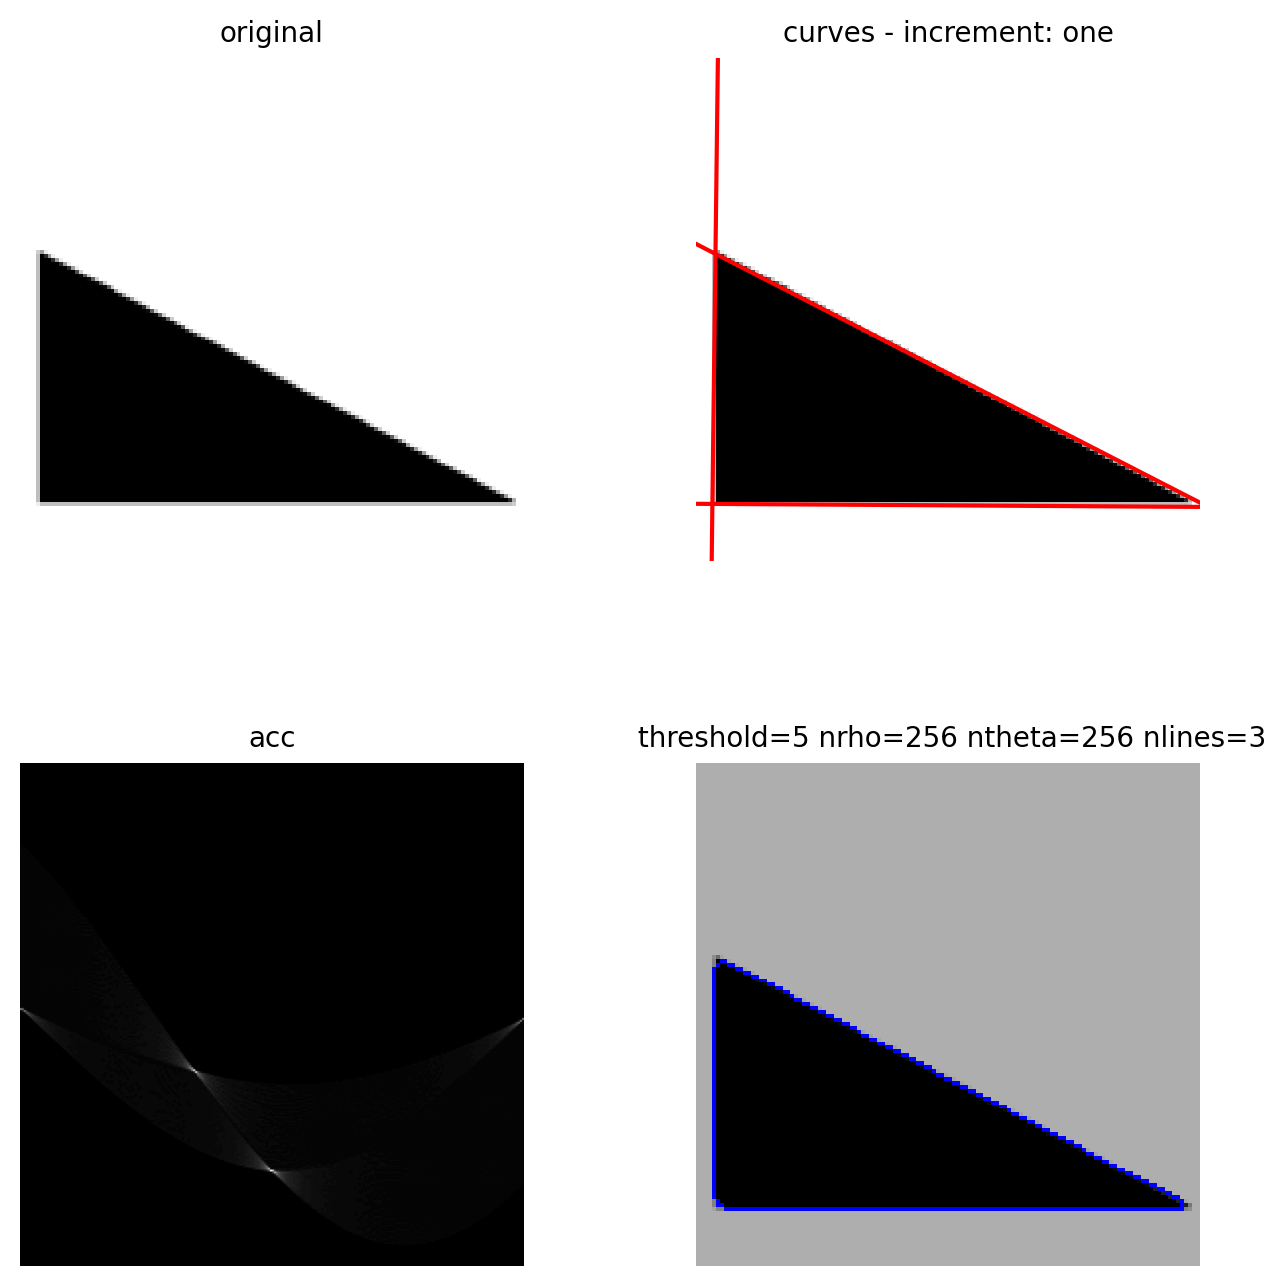

In [ ]:
linepar, acc = houghedgeline(testimage1, 4, 5, 256, 256, 3)

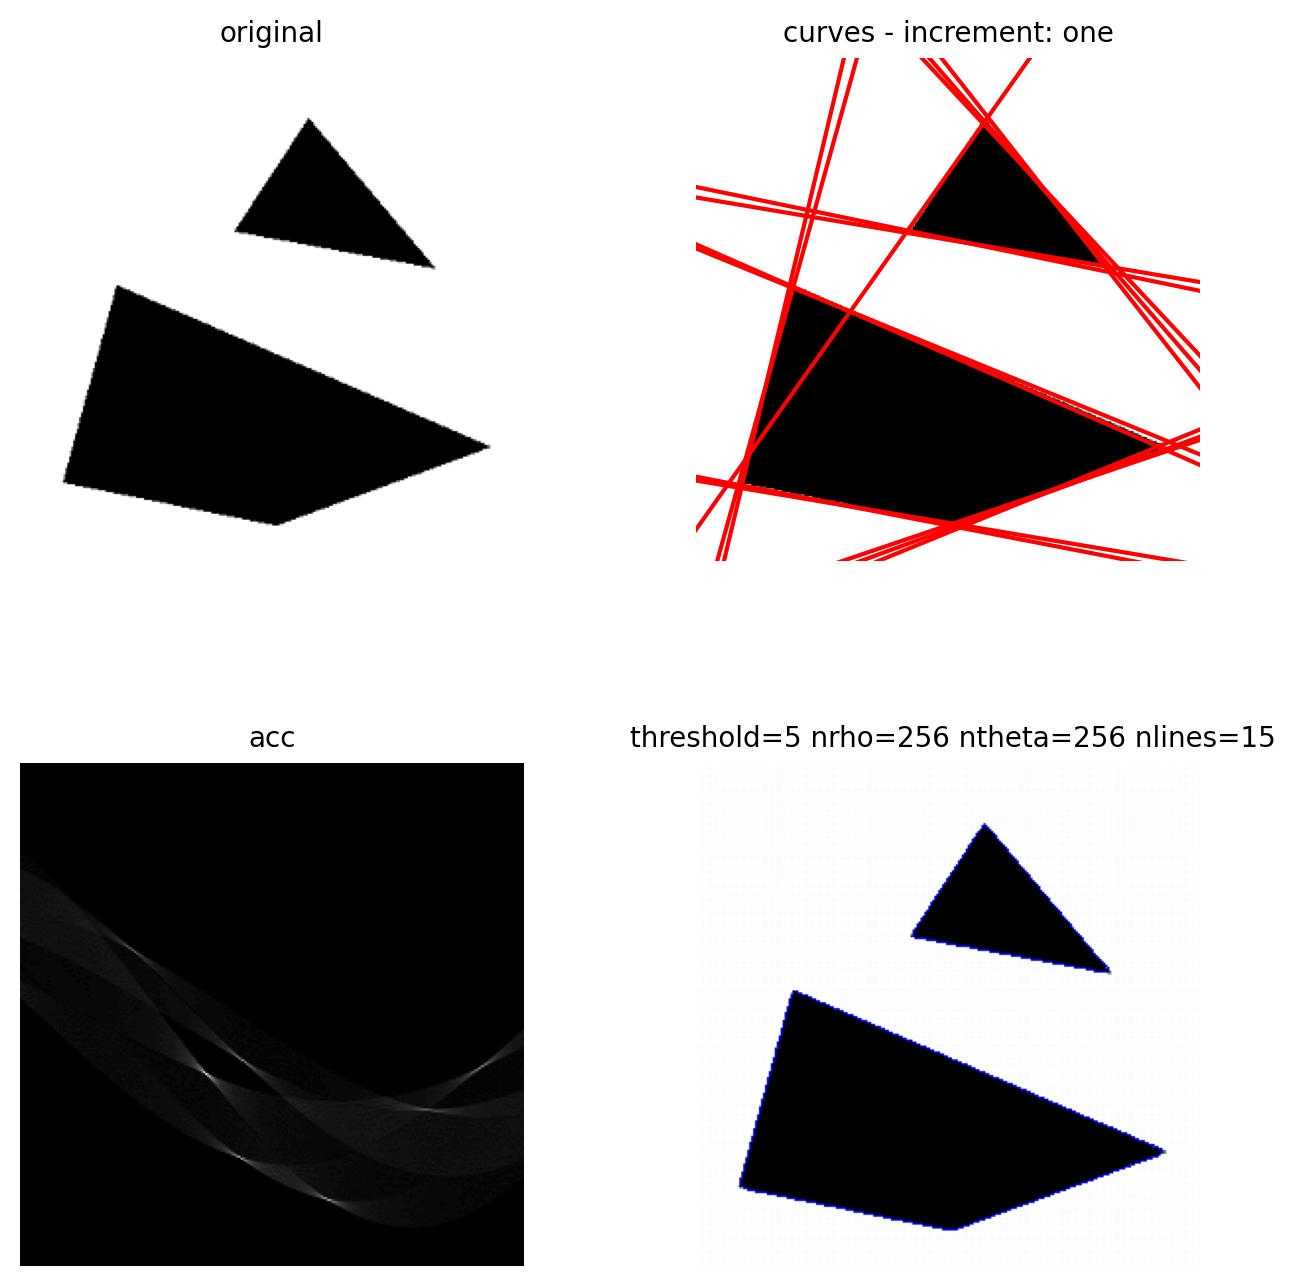

In [ ]:
linepar, acc = houghedgeline(testimage2, 4, 5, 256, 256, 15)

Let's try with different values for nrho and ntheta:

- nrho = 64
- ntheta = 64

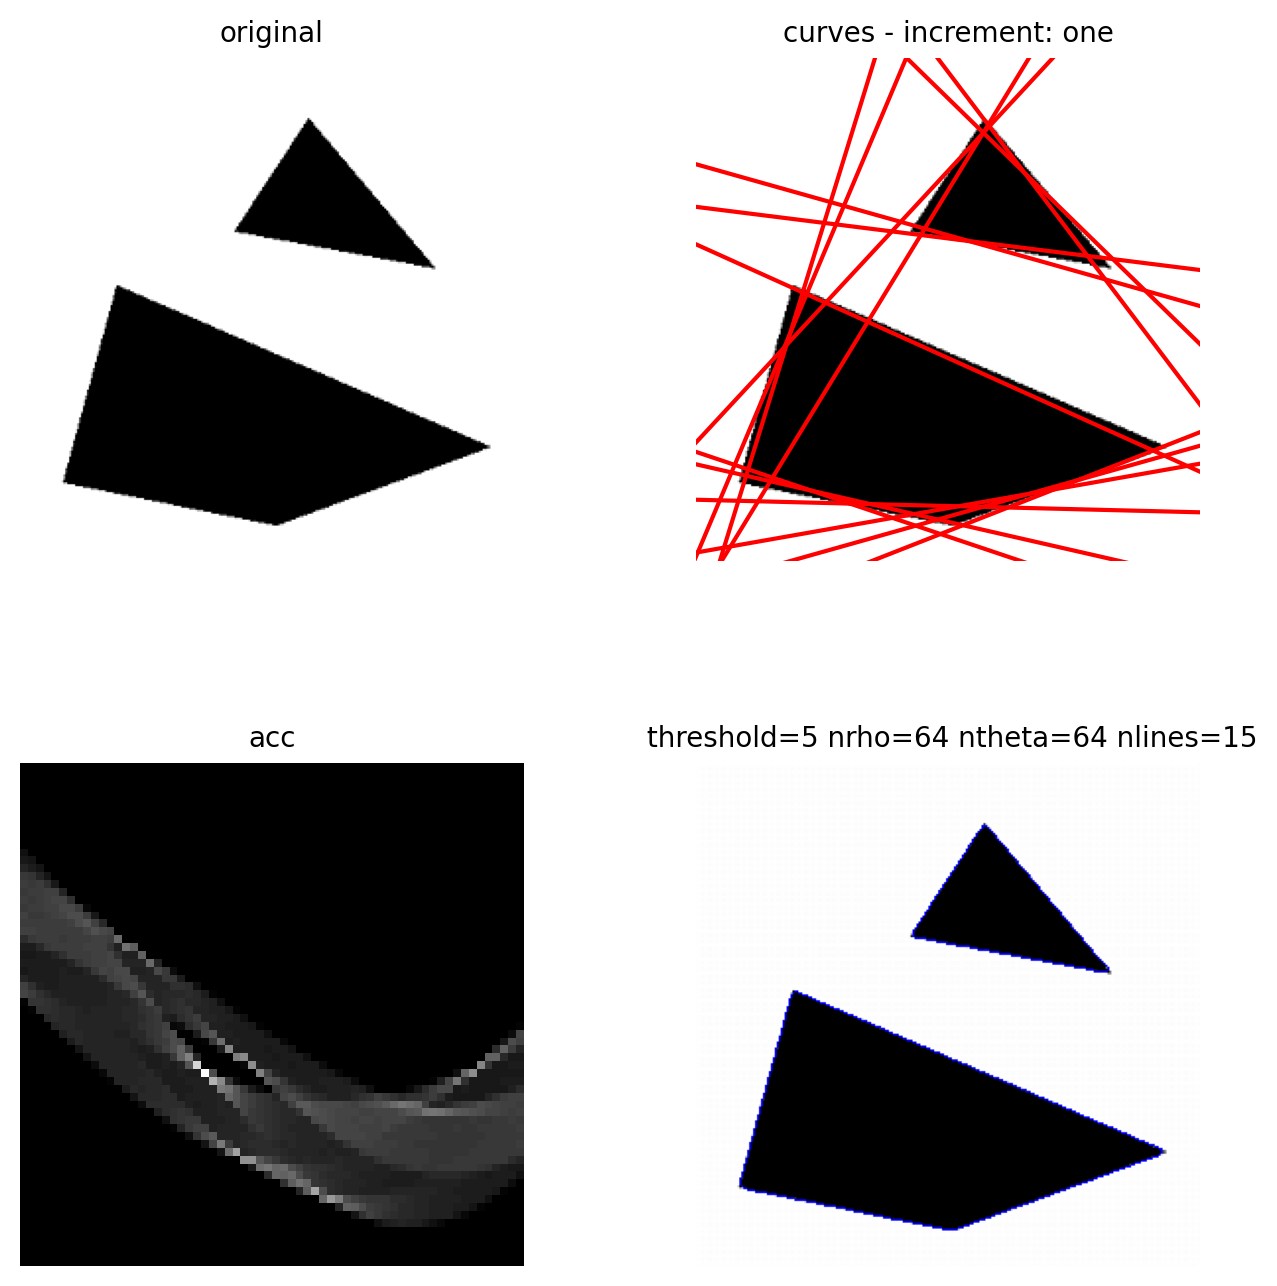

CPU times: user 1.54 s, sys: 35.5 ms, total: 1.57 s
Wall time: 1.56 s


In [ ]:
%%time
linepar, acc = houghedgeline(testimage2, 4, 5, 64, 64, 15)

- nrho = 128
- ntheta = 128

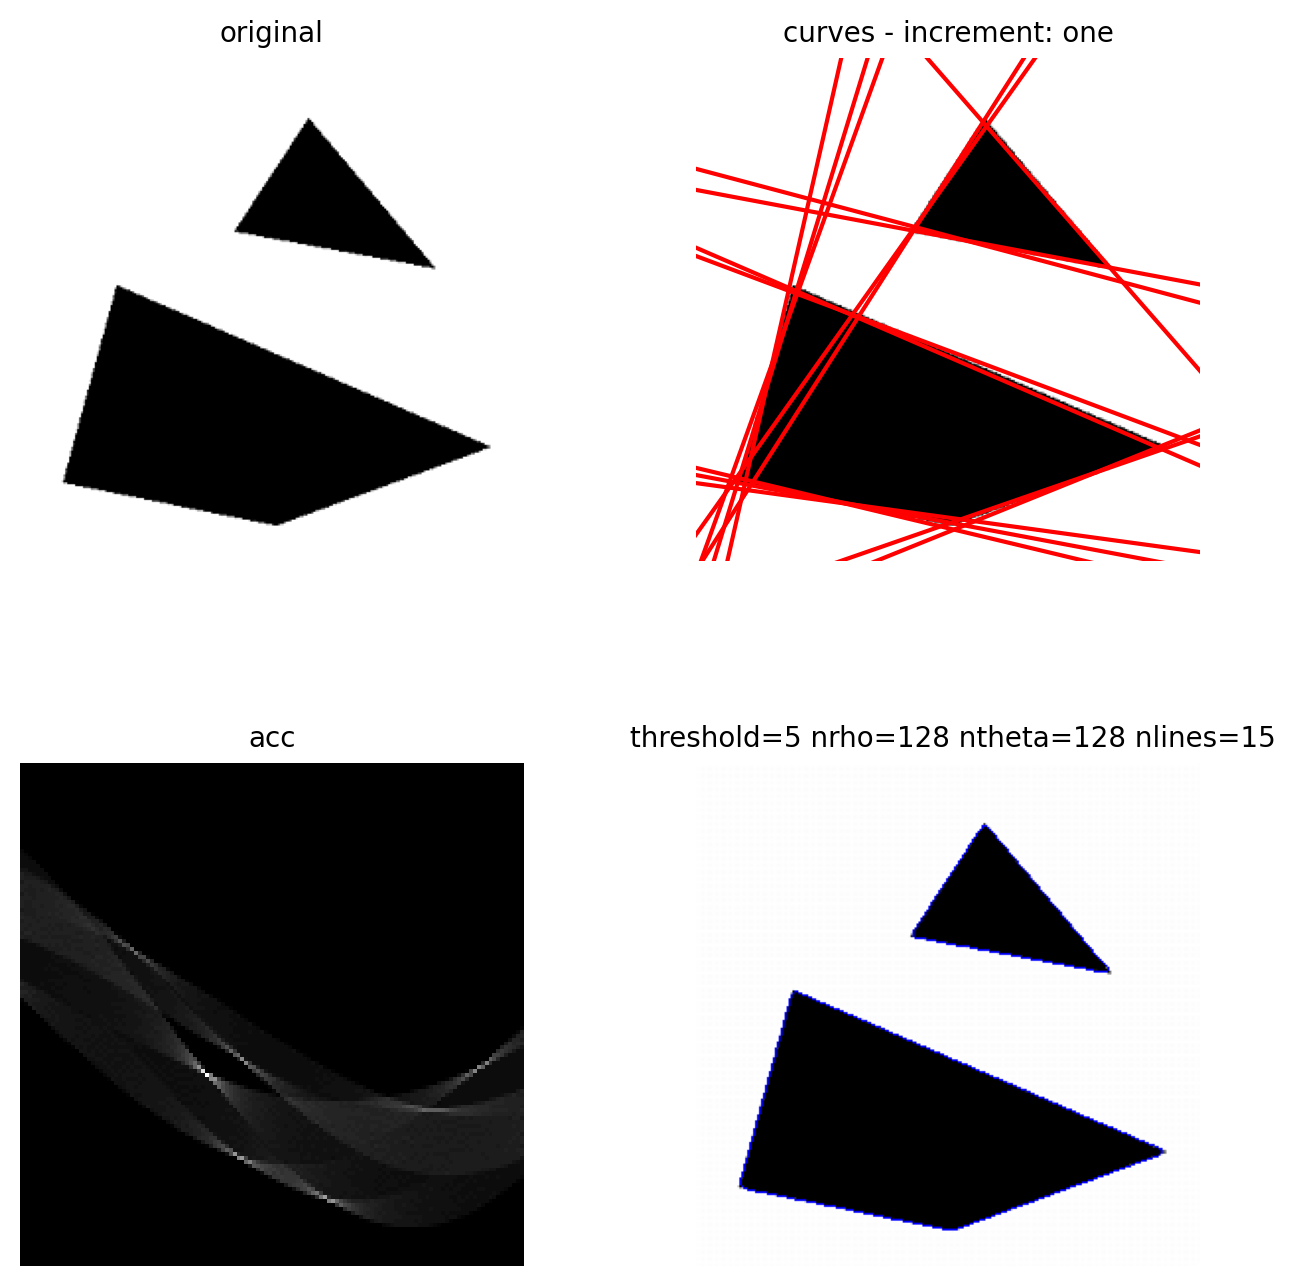

CPU times: user 2.56 s, sys: 161 ms, total: 2.72 s
Wall time: 2.6 s


In [ ]:
%%time
linepar, acc = houghedgeline(testimage2, 4, 5, 128, 128, 15)

- nrho = 128
- theta = 256

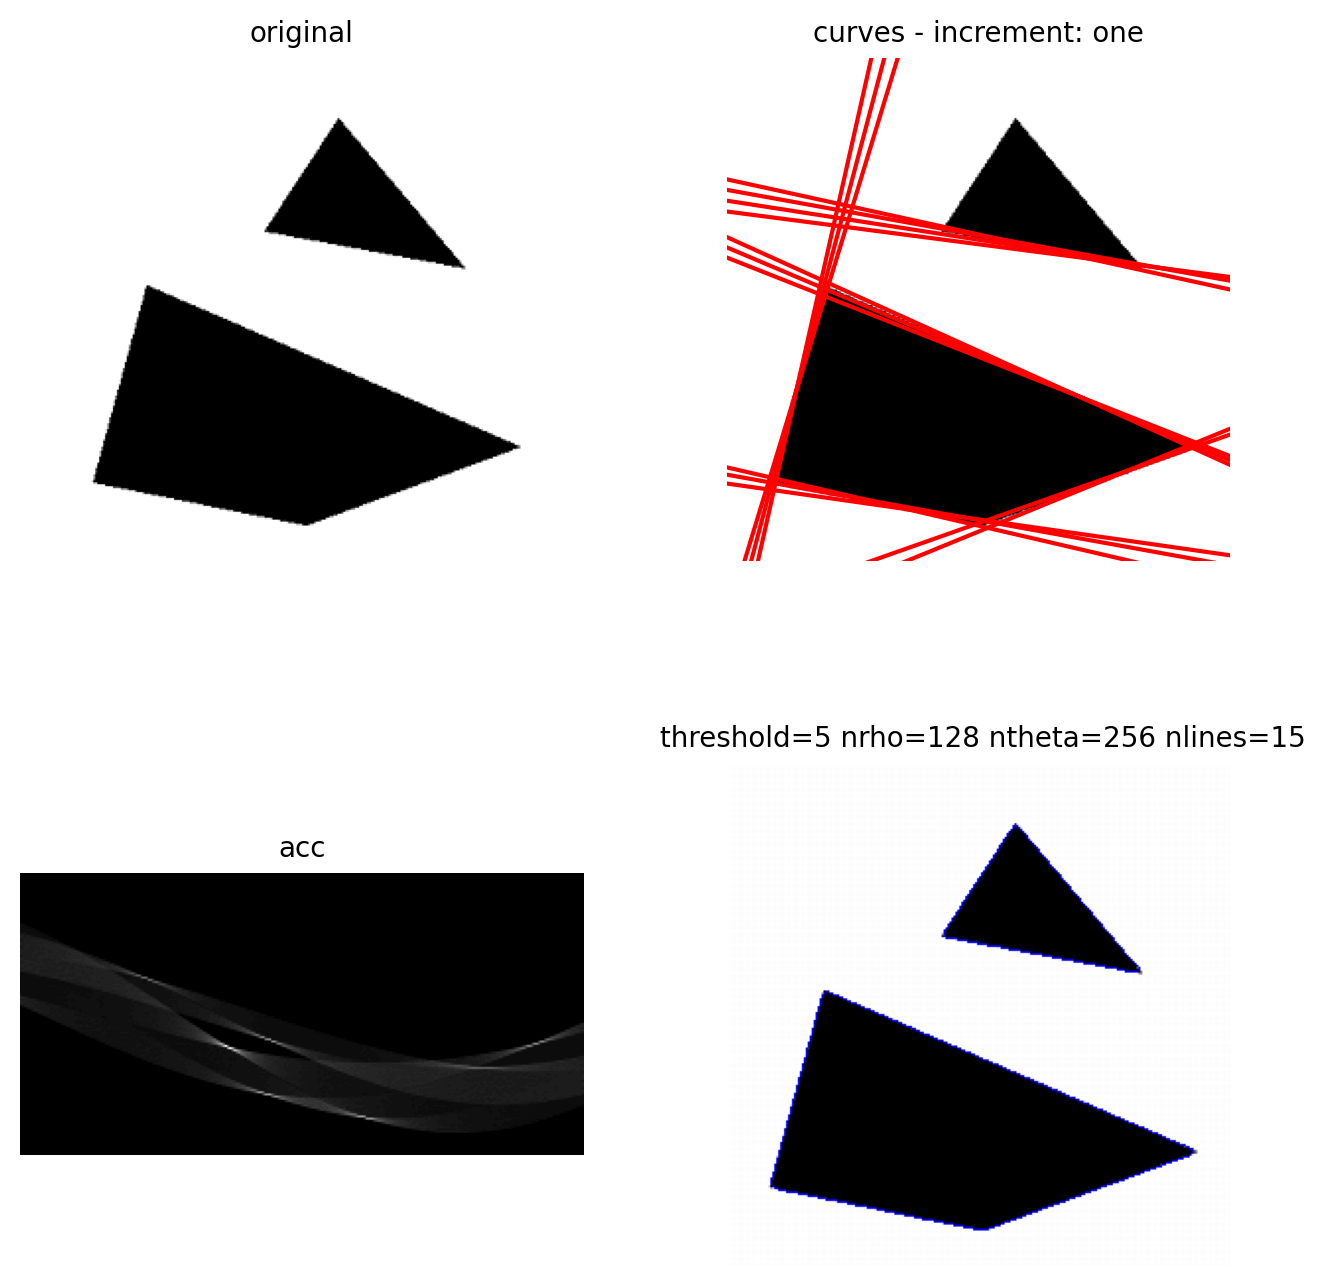

CPU times: user 4.55 s, sys: 414 ms, total: 4.96 s
Wall time: 4.56 s


In [ ]:
%%time
linepar, acc = houghedgeline(testimage2, 4, 5, 128, 256, 15)

- nrho = 256
- ntheta = 128

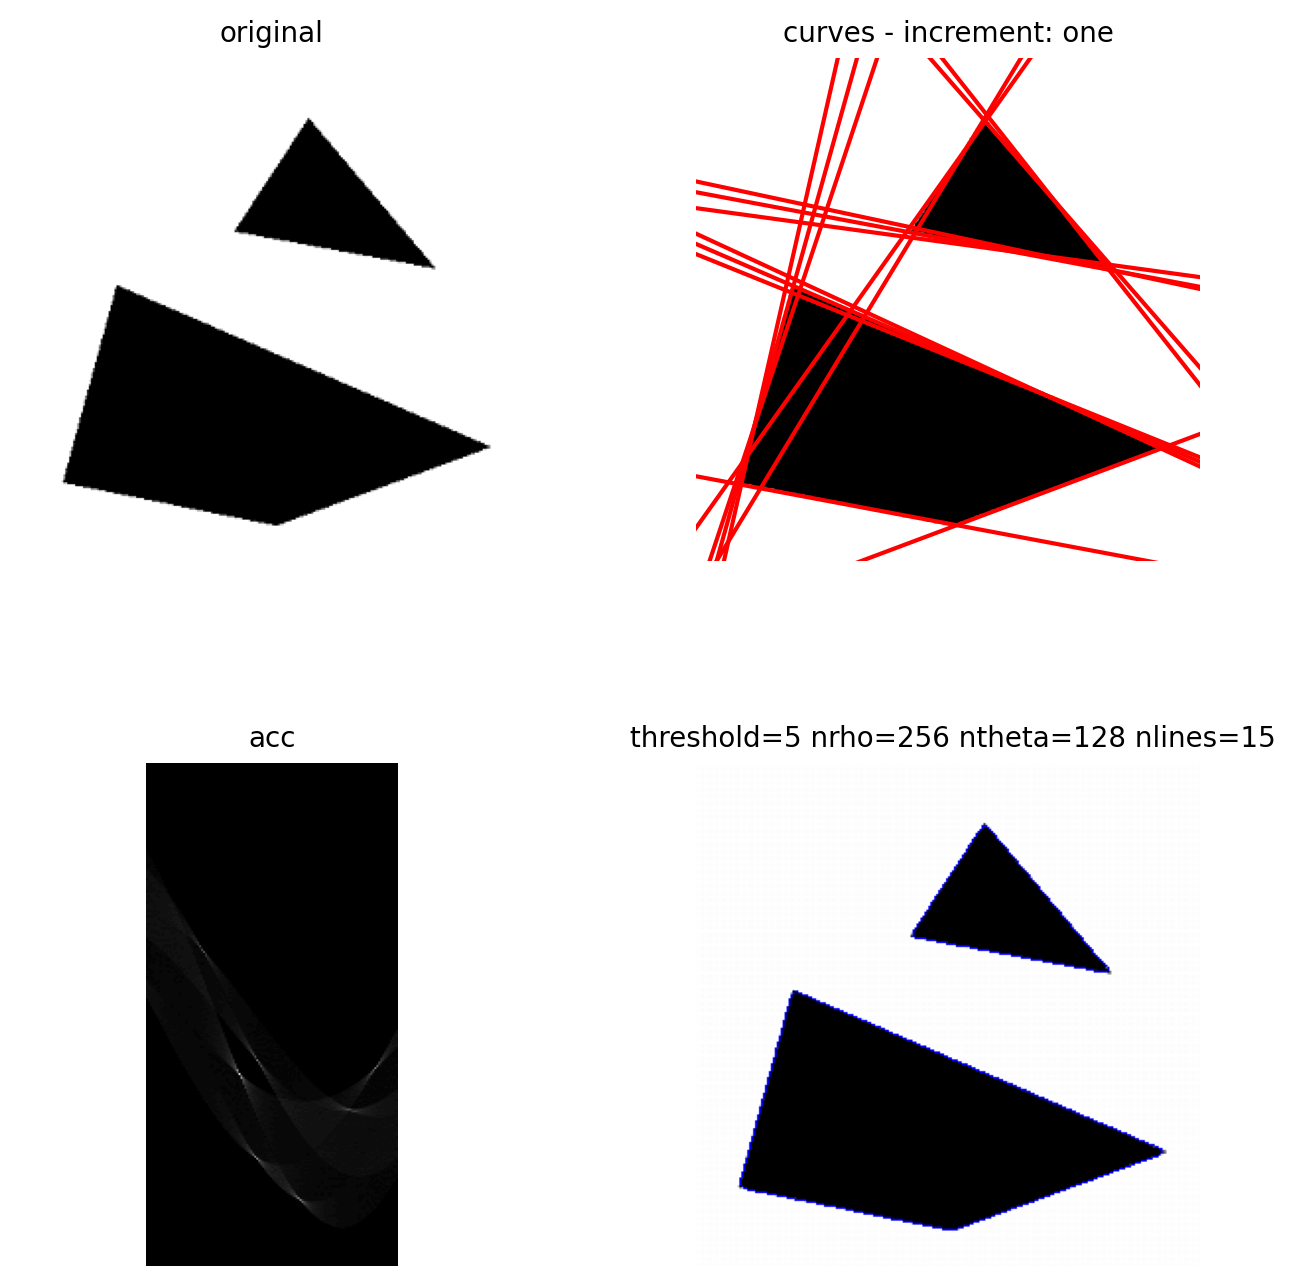

CPU times: user 2.38 s, sys: 80.1 ms, total: 2.46 s
Wall time: 2.4 s


In [ ]:
%%time
linepar, acc = houghedgeline(testimage2, 4, 5, 256, 128, 15)

- nrho = 256
- theta = 256

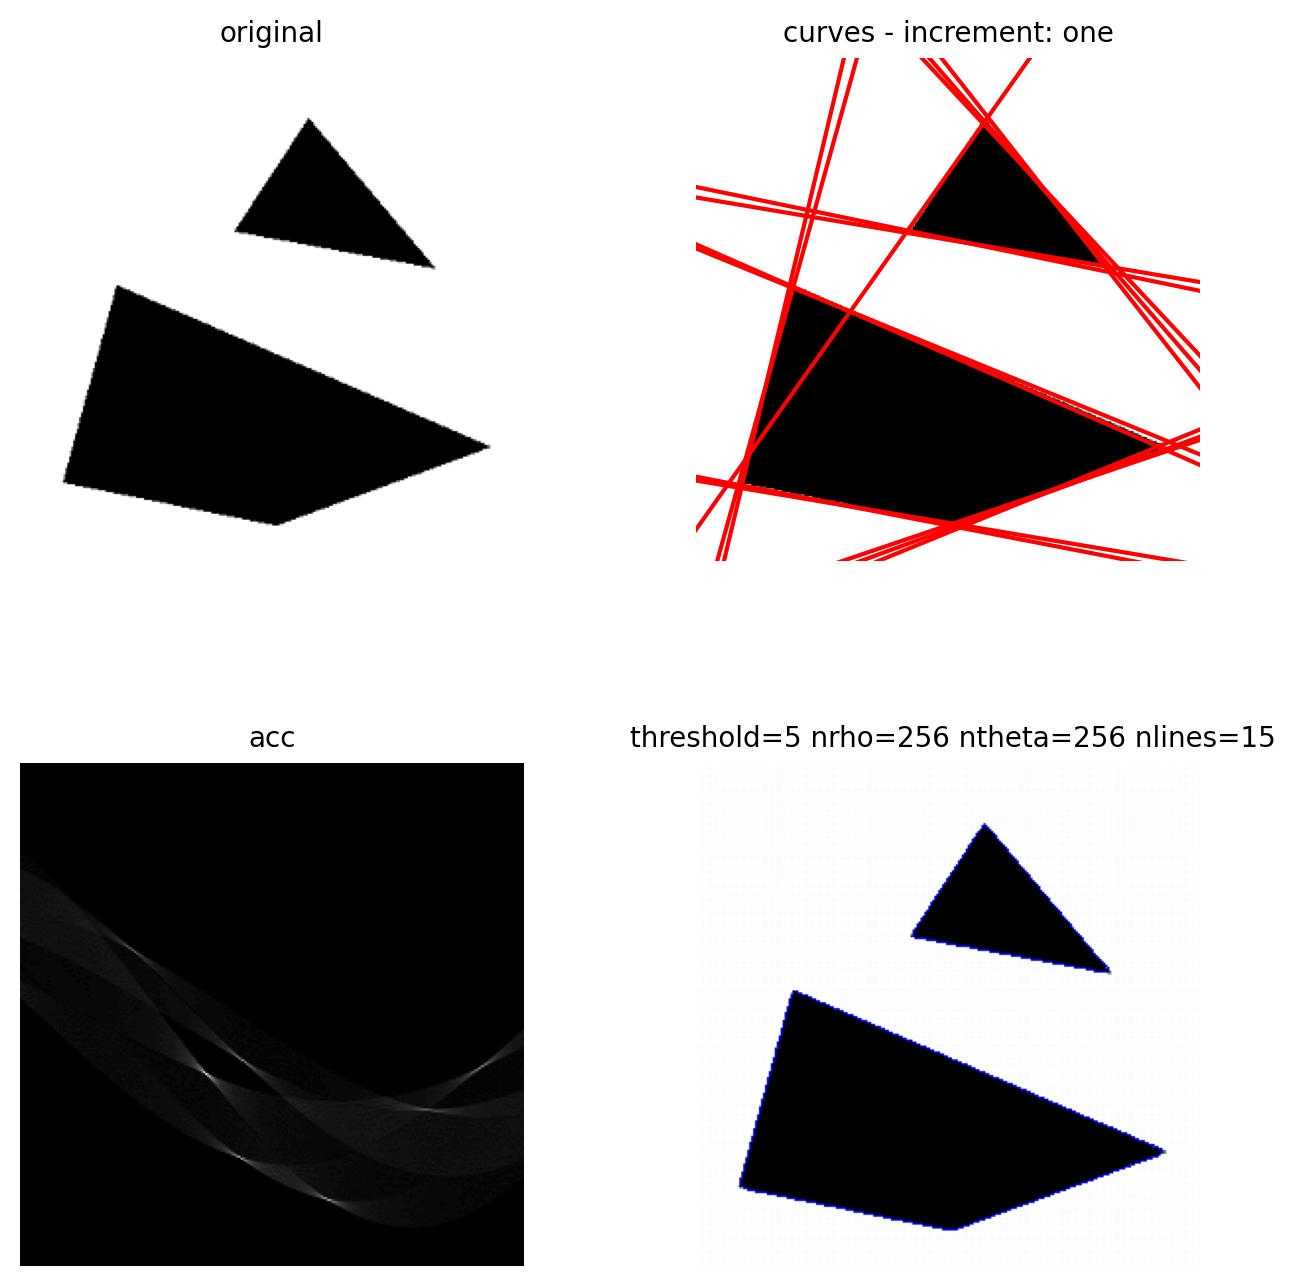

CPU times: user 4.39 s, sys: 285 ms, total: 4.67 s
Wall time: 4.43 s


In [ ]:
%%time
linepar, acc = houghedgeline(testimage2, 4, 5, 256, 256, 15)

**Question 9**: By decreasing the number of cells in both the theta and rho accumulators we will end up with a grainier texture when printing the “acc” matrix (we will have a smaller set of available values of rho and theta to compute the Hough transform of the image). This equates to overall less precise results, which will however require less CPU time. If instead we increase the size of the accumulators, we will have better results which will on average require more time to be obtained. Clearly, increasing the parameters will increase the matrix dimensions, which makes it very clear why more computational time is required, since more computations have to be performed. We have also observed that increasing theta impacts computations more since the algorithm can explore more directions.

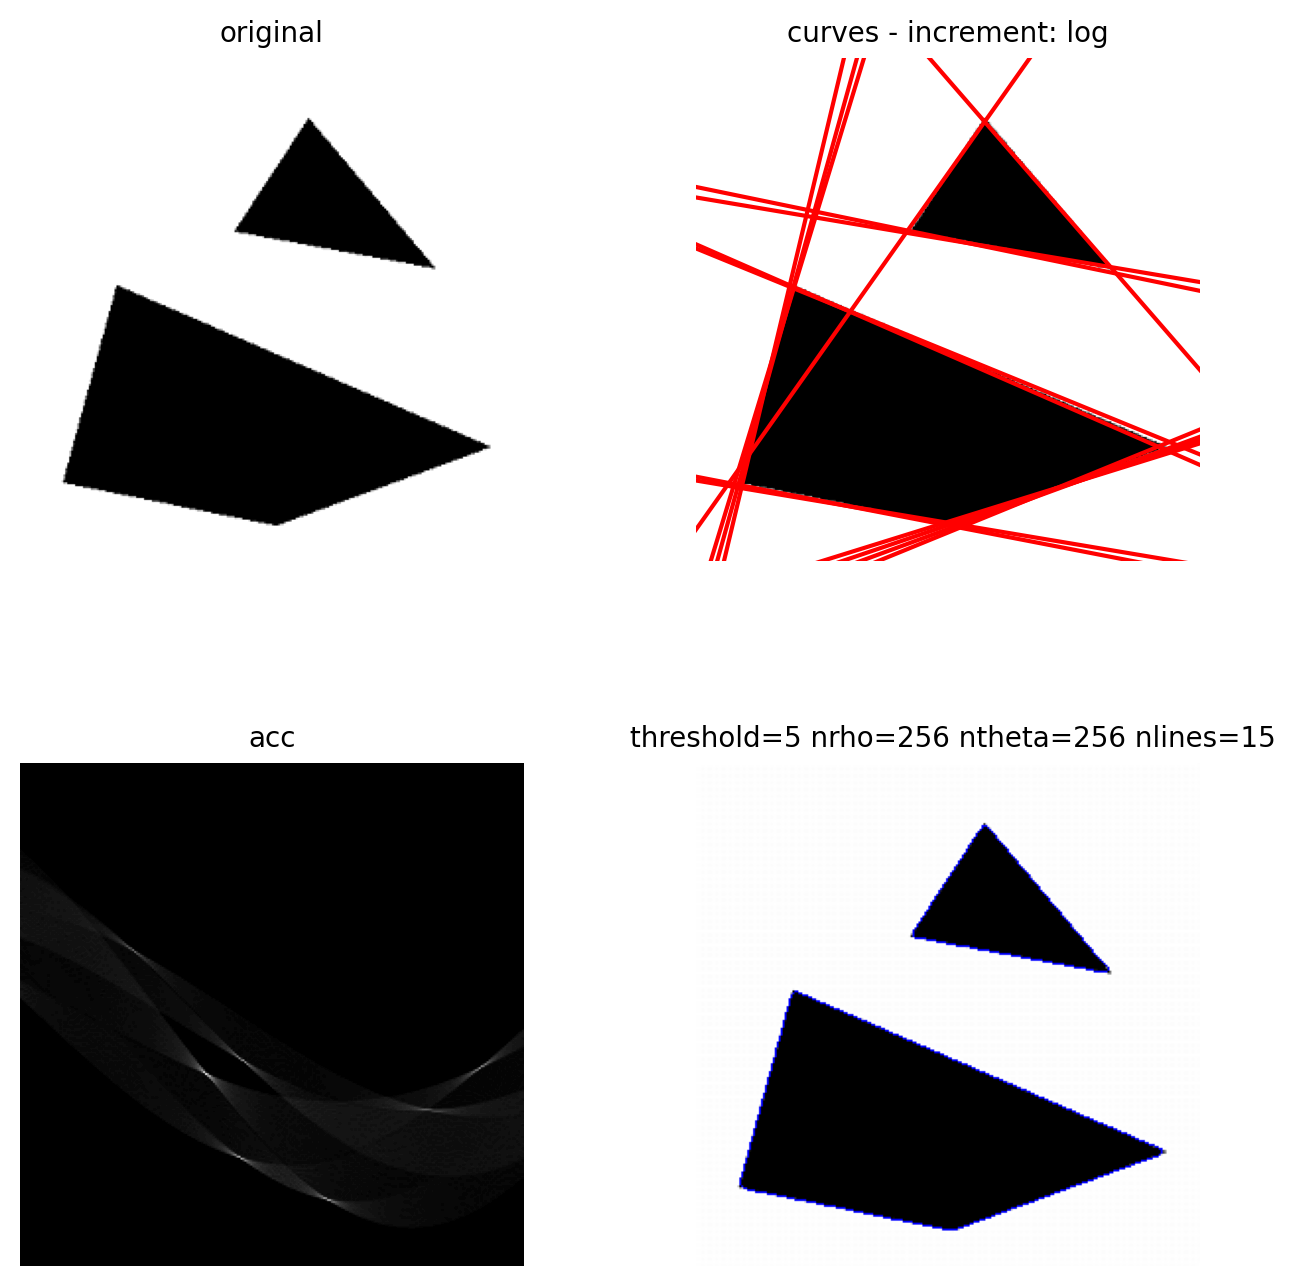

In [ ]:
linepar, acc = houghedgeline(testimage2, 4, 5, 256, 256, 15, increment="log")

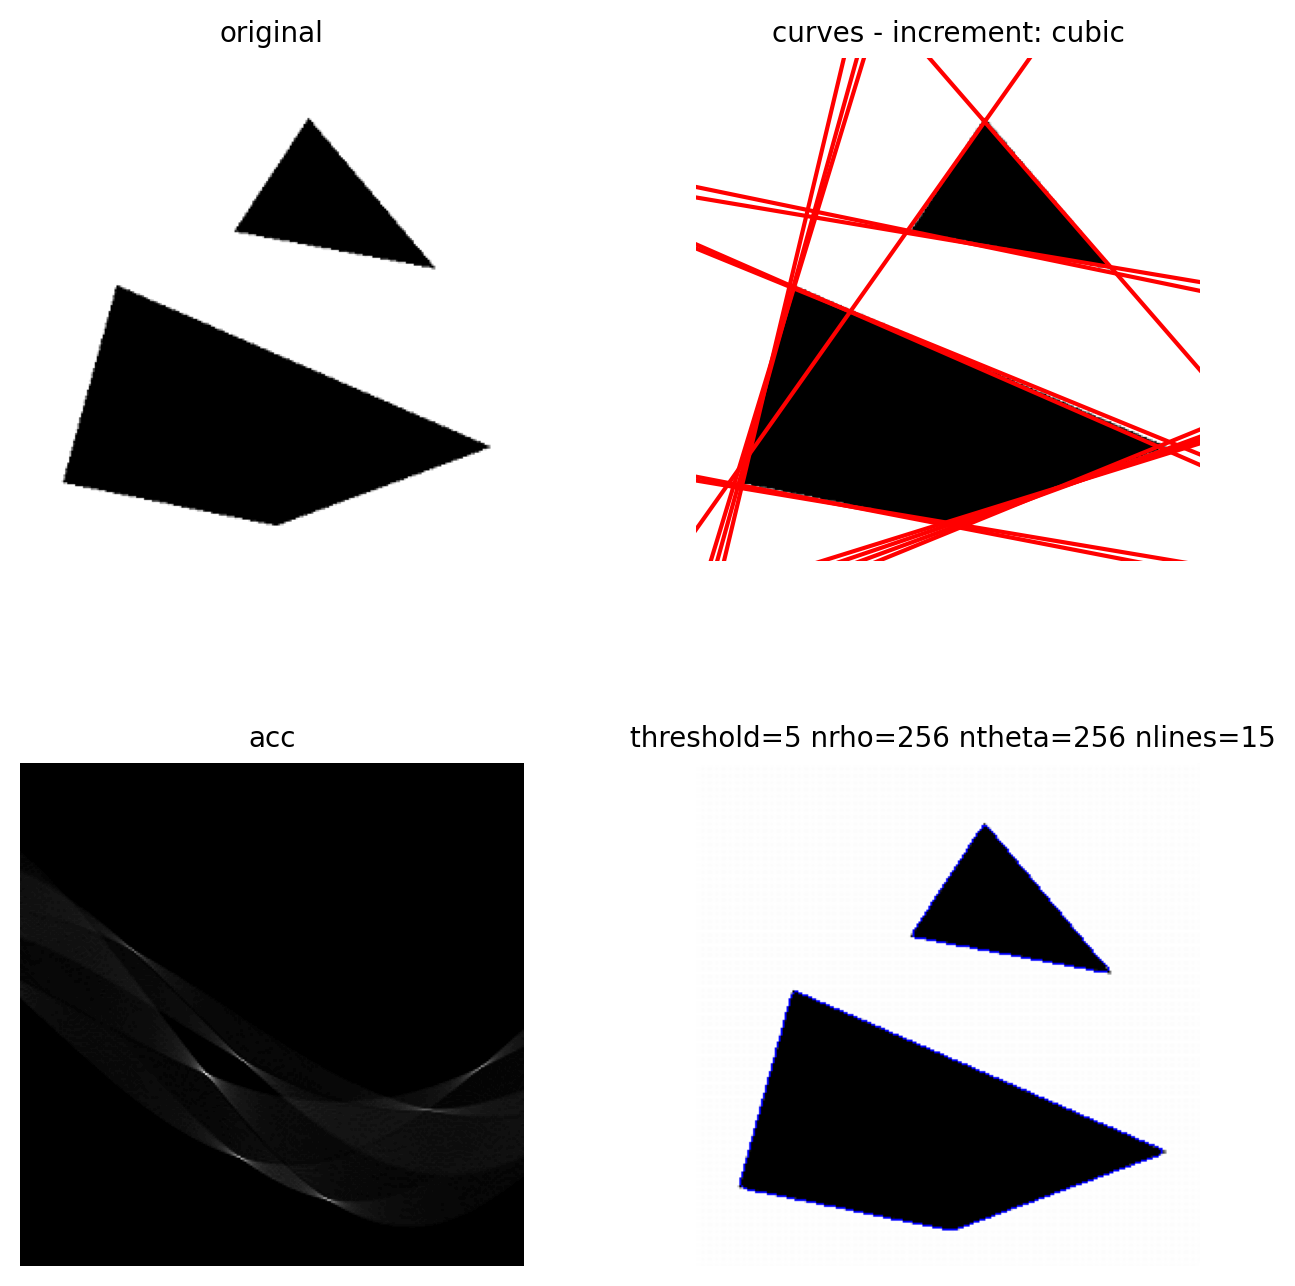

In [ ]:
linepar, acc = houghedgeline(testimage2, 4, 5, 256, 256, 15, increment="cubic")

Choice of accumulator incrementation function:

Kepping it at increment = 1:

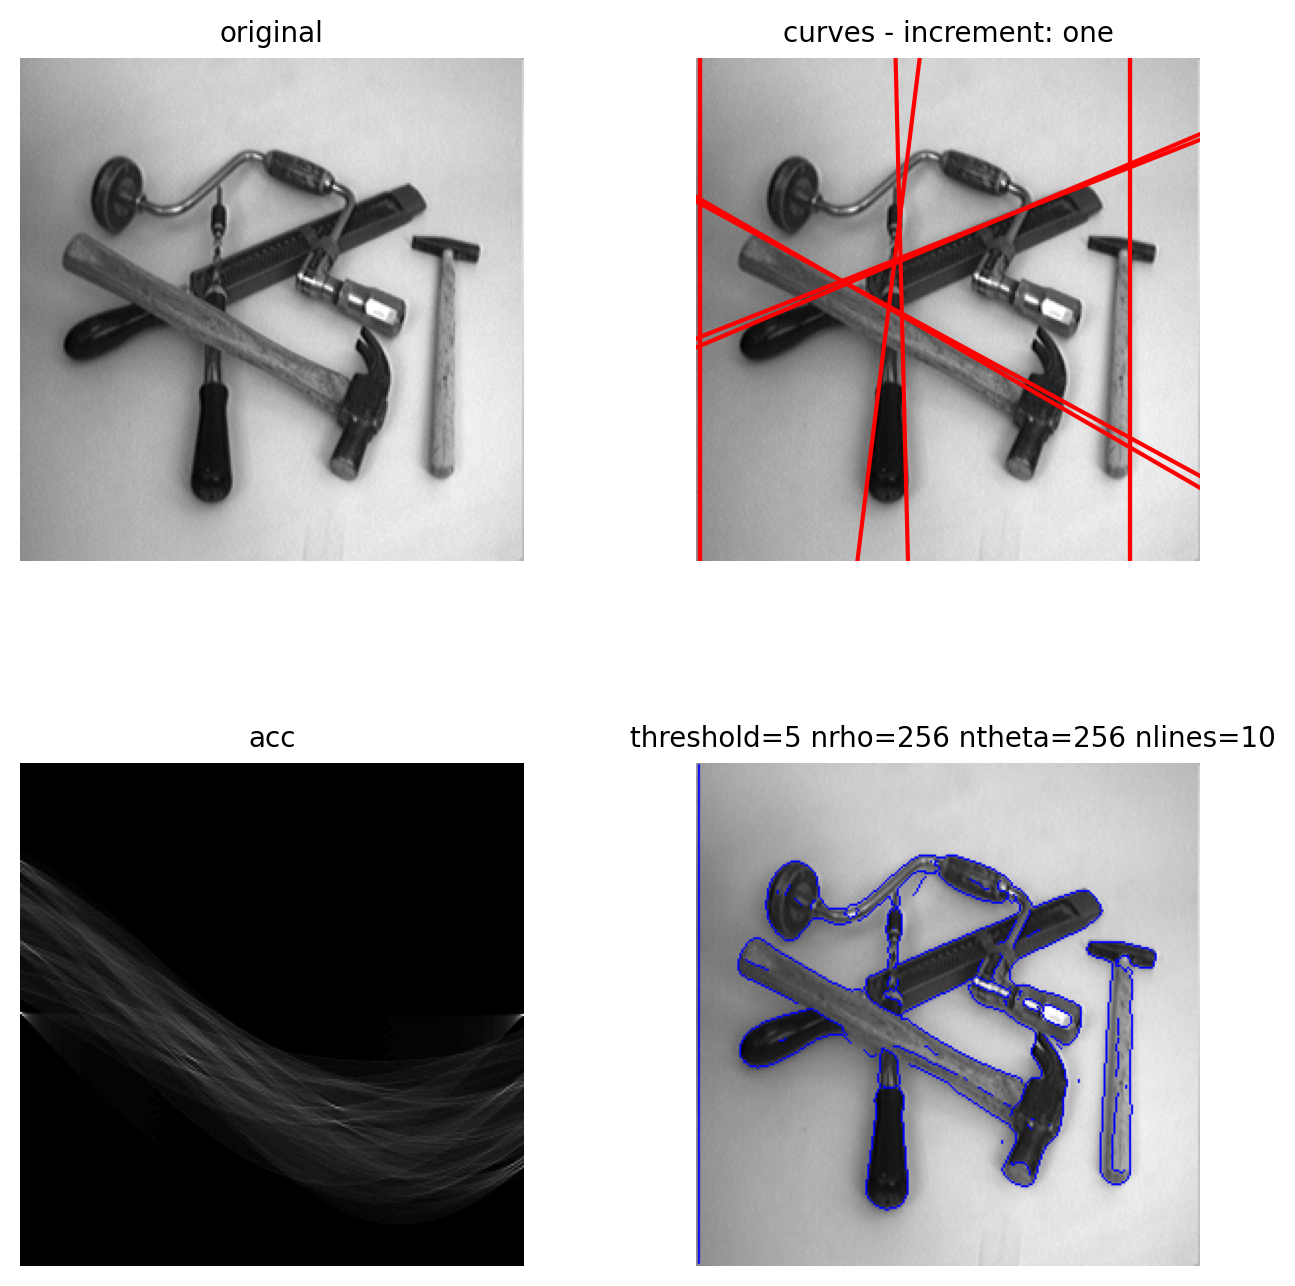

In [ ]:
linepar, acc = houghedgeline(tools, 4, 5, 256, 256, 10)

Increment = *log(magnitude)*:

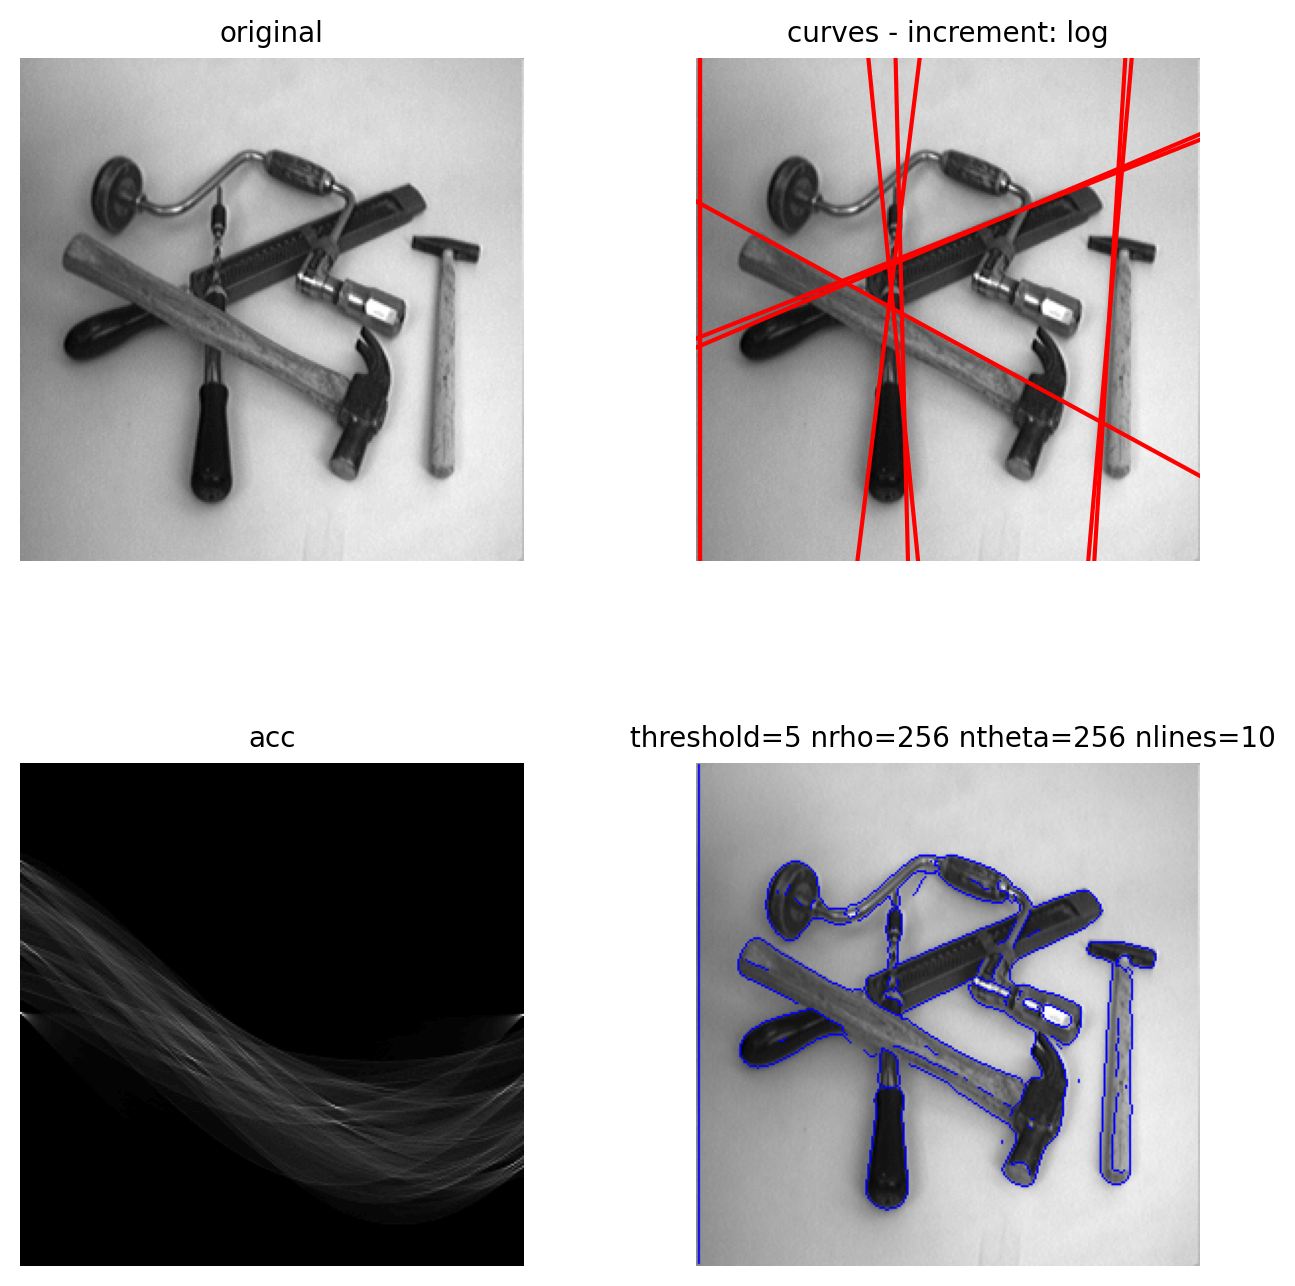

In [ ]:
linepar, acc = houghedgeline(tools, 4, 5, 256, 256, 10, increment="log")

Increment = *magnitude$^3$*

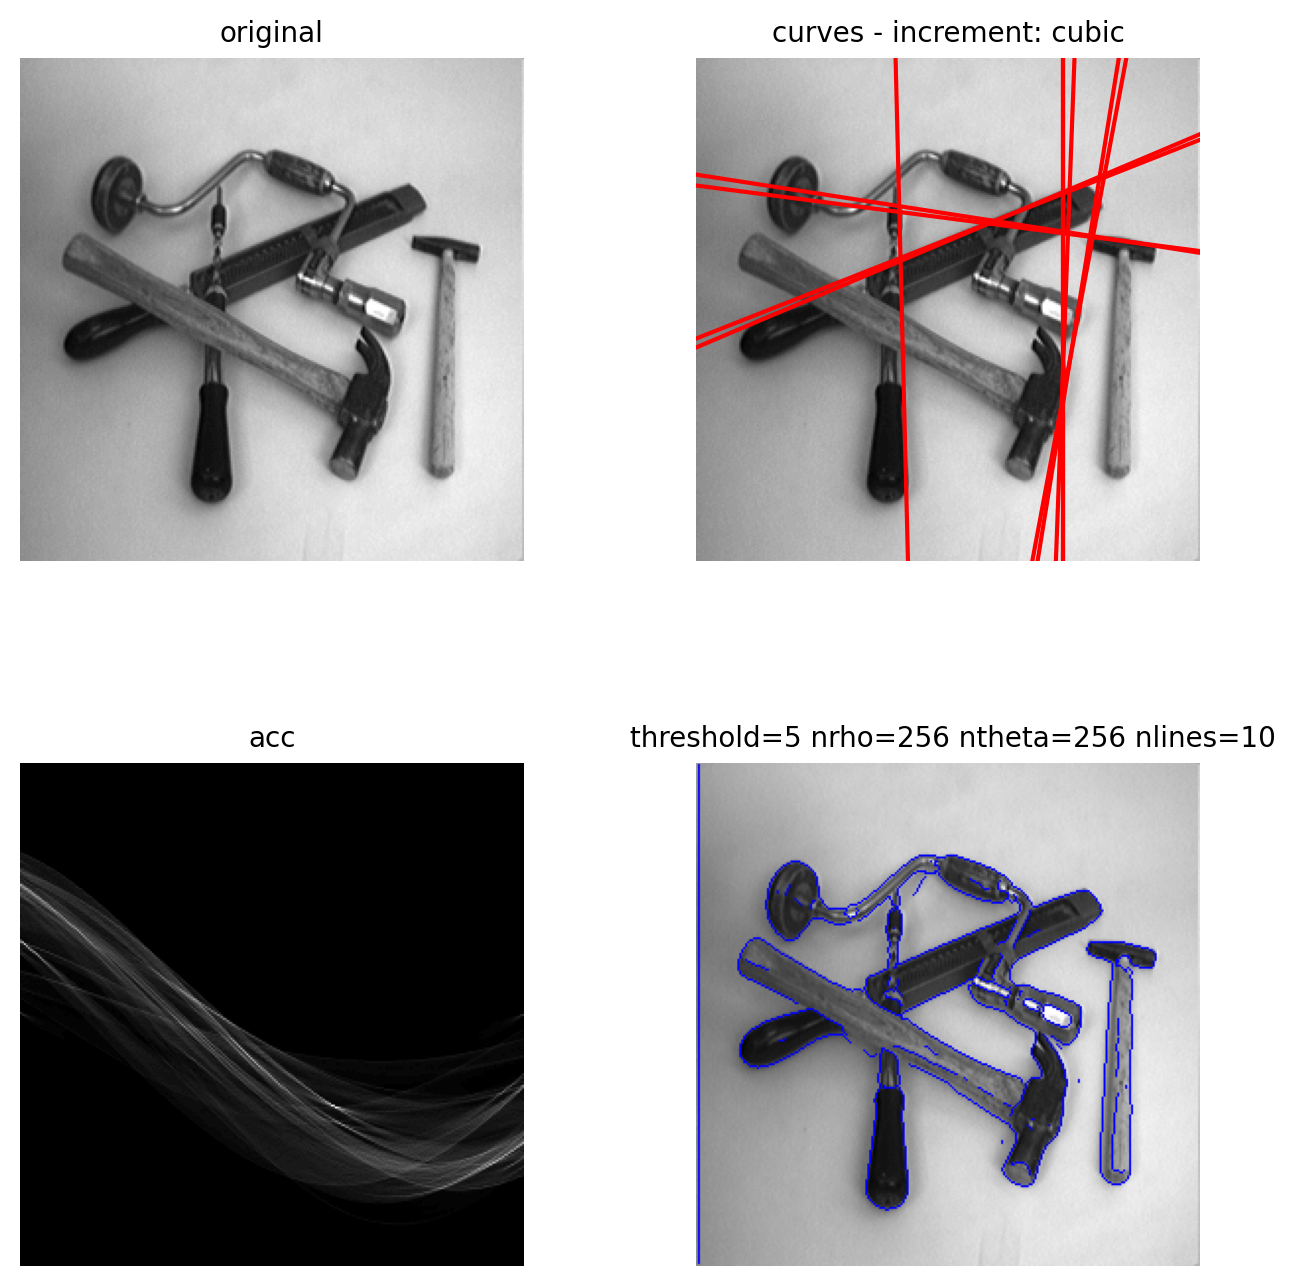

In [ ]:
linepar, acc = houghedgeline(tools, 4, 5, 256, 256, 10, increment="cubic")

**Question 10:** How do you propose to do this? Try out a function that you would suggest and see if it improves the results. Does it?


We tried two different methodologies to define the accumulator increment according to the gradient magnitude:

*  log: instead of incrementing the accumulator by one, we increment it by taking its natural logarithm
*  cubic: instead of incrementing the accumulator by one, we increment it by taking its the cube

These approaches will result in different importance attributed to the detected edges. When taking the cube, lines associated with more evident edges (i.e. higher gradient magnitudes) will increase in importance with respect to the base case (increment = 1).

By looking at the structure of the function used for the increment, we can give more importance to higher gradient magnitudes and, for instance, take more dark lines with increment = “cubic”, as their gradient will be increased by power = 3. In practice, this will result in a different definition of importance weights, with respect to the uniform weights we had in the case of increment = 1.


In [ ]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/CV_Labs/lab2-computervision.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/CV_Labs/lab2-computervision.ipynb to html
[NbConvertApp] Writing 8283121 bytes to /content/drive/MyDrive/CV_Labs/lab2-computervision.html
